# **INSTRUCTION**

E-commerce is evolving day by day. The excutives should pay attention to reviews from the customers. Theses reviews reflect the customers' satisfactions. This report will classify over 11000 reviews from Tiki into 2 categoories: positive and negative. 

# **IMPORT LIBRARIES**

In [1]:
# !pip install wordcloud
# !pip install pyvi
# !pip install -U gensim

In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import multiprocessing
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import roc_curve
import tensorflow as tf
from keras import models
from keras import layers
from tensorflow.keras.models import Sequential
from gensim.models import Word2Vec, Phrases
from pyvi import ViPosTagger, ViTokenizer #Tokenize ti·∫øng Vi·ªát
import wordcloud
import gensim
from gensim.models import Word2Vec
from tensorflow.keras.layers import Dropout, Activation, TimeDistributed, Conv1D, Dense, Embedding, Flatten, Input, MaxPooling1D, LSTM, Bidirectional, Activation, GRU

# **EXPLORING THE DATA**

In [2]:
xl = pd.ExcelFile('data.xlsx')
for name in xl.sheet_names:
    data = xl.parse(name)

In [3]:
data.head(10)

Rating                                            Content
0       5  1234570000000000120924793754905402008253644144...
1       5  "Cu·ªôc h√†nh tr√¨nh ng√†n d·∫∑m n√†o c≈©ng ph·∫£i b·∫Øt ƒë·∫ß...
2       5  *Th·∫≠t s·ª± r·∫•t ƒë√°ng ti·ªÅn khi mua cu·ªën s√°ch n√†y ƒë...
3       5                                                  ,
4       5                                                  .
5       5                                                  .
6       5                          .!-?:‚Äô kh√° ƒë·∫πp v√† d·ªÖ d√πng
7       5  .................................................
8       5  ....B√∫t d√πng t·ªët, m√†u s·∫Øc ƒë·∫πp, ƒë√°ng gi√°,n√™n mu...
9       5                                                : D

In [4]:
data.shape

(11269, 2)

The data set has 11600 records and 3 features.

In [5]:
data.dtypes

Rating      int64
Content    object
dtype: object

The data have 3 features:
- "Rating" contains integer values which show the level of goods and service ratings. 
- "Title" haves object values show general reviews.
- "Content" haves object values show detailed reviews about goods as well as services.

In [6]:
display(data.isnull().sum()/len(data)) 

Rating     0.0
Content    0.0
dtype: float64

Checking NULL values, we can see that there are about 3% reviews that not have *Content*. We convert NaN values to string values.

In [7]:
for i in range(len(data)):
    data.Content[i] = str(data.Content[i])

<ipython-input-7-b350449444a3>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.Content[i] = str(data.Content[i])


In [8]:
display(data.isnull().sum()/len(data)) 

Rating     0.0
Content    0.0
dtype: float64

There are no more NULL values.

In [9]:
fig = px.histogram(data, x="Rating")
fig.show()

From the plot, we can see that there are so many positive ratings (4 or 5 stars). There are very few reviews rated below 4 stars.

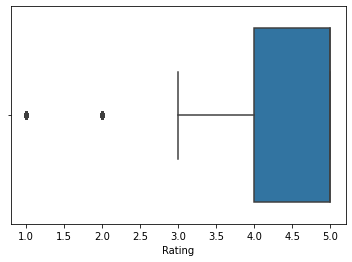

In [11]:
ax = sns.boxplot(x=data['Rating'])
plt.show()

# **PROCESSING DATA**

Before using model to classify reviews, we need to process the data. Firstly, we will classify "Rating" into two categories, which is greater than 3 will be rated at positive and vice versa.

In [10]:
data["Rating"] = [1 if each > 3 else 0 for each in data["Rating"]]
data.head(10)

Rating                                            Content
0       1  1234570000000000120924793754905402008253644144...
1       1  "Cu·ªôc h√†nh tr√¨nh ng√†n d·∫∑m n√†o c≈©ng ph·∫£i b·∫Øt ƒë·∫ß...
2       1  *Th·∫≠t s·ª± r·∫•t ƒë√°ng ti·ªÅn khi mua cu·ªën s√°ch n√†y ƒë...
3       1                                                  ,
4       1                                                  .
5       1                                                  .
6       1                          .!-?:‚Äô kh√° ƒë·∫πp v√† d·ªÖ d√πng
7       1  .................................................
8       1  ....B√∫t d√πng t·ªët, m√†u s·∫Øc ƒë·∫πp, ƒë√°ng gi√°,n√™n mu...
9       1                                                : D

In [11]:
fig = px.histogram(data, x="Rating")
fig.show()

In [12]:
data['Rating'].value_counts() / len(data)

1    0.849232
0    0.150768
Name: Rating, dtype: float64

Nh·∫≠n x√©t: c√≥ nh·ªØng t·ª´ kh√¥ng ƒë√∫ng ch√≠nh t·∫£, d·∫•u thanh ƒëi·ªáu kh√¥ng t∆∞∆°ng th√≠ch v√≠ d·ª• "h√≤a" v√† "ho√†", c√°c emoji mang s·∫Øc th√°i t√≠ch c·ª±c v√† ti√™u c·ª±c, teencode,... Tr∆∞·ªõc h·∫øt c·∫ßn ƒë·ªìng nh·∫•t nh·ªØng c√°i n√†y 

Change strings to lowercase

In [13]:
data['Content'] = data['Content'].str.lower()
data.head(10)

Rating                                            Content
0       1  1234570000000000120924793754905402008253644144...
1       1  "cu·ªôc h√†nh tr√¨nh ng√†n d·∫∑m n√†o c≈©ng ph·∫£i b·∫Øt ƒë·∫ß...
2       1  *th·∫≠t s·ª± r·∫•t ƒë√°ng ti·ªÅn khi mua cu·ªën s√°ch n√†y ƒë...
3       1                                                  ,
4       1                                                  .
5       1                                                  .
6       1                          .!-?:‚Äô kh√° ƒë·∫πp v√† d·ªÖ d√πng
7       1  .................................................
8       1  ....b√∫t d√πng t·ªët, m√†u s·∫Øc ƒë·∫πp, ƒë√°ng gi√°,n√™n mu...
9       1                                                : d

In [14]:
for i in range(len(data)):
    data['Content'][i] =  data['Content'][i].replace(':3','')
    data['Content'][i] =  data['Content'][i].replace(':v','')
    data['Content'][i] =  data['Content'][i].replace(':o','')
    data['Content'][i] =  data['Content'][i].replace('"','')

<ipython-input-14-395b992a9395>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-14-395b992a9395>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-14-395b992a9395>:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-14-395b992a9395>:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pand

In [15]:
data['Content'] = data['Content'].str.replace('[{}]'.format(",#.:@;()$`~/-\^<>+=!"), '')
data

<ipython-input-15-3ae06f39e333>:1: FutureWarning:

The default value of regex will change from True to False in a future version.



Rating                                            Content
0           1                                                   
1           1  cu·ªôc h√†nh tr√¨nh ng√†n d·∫∑m n√†o c≈©ng ph·∫£i b·∫Øt ƒë·∫ßu...
2           1  *th·∫≠t s·ª± r·∫•t ƒë√°ng ti·ªÅn khi mua cu·ªën s√°ch n√†y ƒë...
3           1                                                   
4           1                                                   
...       ...                                                ...
11264       0     y√™u c·∫ßu shop x√°c nh·∫≠n ƒë∆°n h√†ng d√πm l√¢u qu√° r·ªìi
11265       0  y√™u c·∫ßu tiki d√°n tem h√†ng d·ªÉ v·ª° mua bia v·ªÅ l√†m...
11266       0  y√™u c·∫ßu tiki l√†m vi·ªác v·ªõi b√™n v·∫≠n chuy·ªÉn giao ...
11267       0  y√™u c√¢u tiki x√°c nh·∫≠n c√≥ ƒë√∫ng ch√≠nh x√°c l√† ino...
11268       0  y√™u c√¢u tiki x√°c nh·∫≠n c√≥ ƒë√∫ng ch√≠nh x√°c l√† ino...

[11269 rows x 2 columns]

In [16]:
for i in range(len(data)):
    data['Content'][i] =  ViPosTagger.postagging(ViTokenizer.tokenize(data['Content'][i]))[0]

<ipython-input-16-7c8f8e320705>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [17]:
print(data['Content'][3830])
print(data['Content'][5722])
print(data['Content'][4578])
print(data['Content'][8388])

['m√°y', 'x√†i', 't·ªët', 'ƒë√°ng', 'ƒë·ªìng_ti·ªÅn', 'b√°t', 'g·∫°o']
['s·∫£n_ph·∫©m_ch·∫•t_l∆∞·ª£ng']
['nh·ªè', 'g·ªçn', 'd·ªÖ', 'd√πng']
['h√†i_l√≤ng']


In [18]:
dictionary = {
#     '√≤a': 'o√†', '√≥a': 'o√°', '·ªèa': 'o·∫£', '√µa': 'o√£', '·ªça': 'o·∫°', '√≤e': 'o√®', '√≥e': 'o√©','·ªèe': 'o·∫ª',
#     '√µe': 'o·∫Ω', '·ªçe': 'o·∫π', '√πy': 'u·ª≥', '√∫y': 'u√Ω', '·ªßy': 'u·ª∑', '≈©y': 'u·ªπ','·ª•y': 'u·ªµ', 'u·∫£': '·ªßa',
#     'aÃâ': '·∫£', '√¥ÃÅ': '·ªë', 'u¬¥': '·ªë','√¥ÃÉ': '·ªó', '√¥ÃÄ': '·ªì', '√¥Ãâ': '·ªï', '√¢ÃÅ': '·∫•', '√¢ÃÉ': '·∫´', '√¢Ãâ': '·∫©',
#     '√¢ÃÄ': '·∫ß', 'oÃâ': '·ªè', '√™ÃÄ': '·ªÅ','√™ÃÉ': '·ªÖ', 'ƒÉÃÅ': '·∫Ø', 'uÃâ': '·ªß', '√™ÃÅ': '·∫ø', '∆°Ãâ': '·ªü', 'iÃâ': '·ªâ',
#     'eÃâ': '·∫ª', '√†k': u' √† ','aÀã': '√†', 'iÀã': '√¨', 'ƒÉ¬¥': '·∫Ø','∆∞Ãâ': '·ª≠', 'eÀú': '·∫Ω', 'yÀú': '·ªπ', 'a¬¥': '√°',
    # EMOJI
    "üëπ": 'negative', "üëª": 'positive', "üíÉ": 'positive','ü§ô': 'positive', 'üëç': 'positive',
    "üíÑ": 'positive', "üíé": 'positive', "üí©": 'positive',"üòï": 'negative', "üò±": 'negative', "üò∏": 'positive',
    "üòæ": 'negative', "üö´": 'negative',  "ü§¨": 'negative',"üßö": 'positive', "üß°": 'positive','üê∂': 'positive',
    'üëé': 'negative', 'üò£': 'negative','‚ú®': 'positive', '‚ù£': 'positive','‚òÄ': 'positive',
    '‚ô•': 'positive', 'ü§©': 'positive', 'like': 'positive', 'üíå': 'positive',
    'ü§£': 'positive', 'üñ§': 'positive', 'ü§§': 'positive', 'üò¢': 'negative',
    '‚ù§': 'positive', 'üòç': 'positive', 'üòò': 'positive', 'üò™': 'negative', 'üòä': 'positive',
    'üòÅ': 'positive', 'üíñ': 'positive', 'üòü': 'negative', 'üò≠': 'negative',
    'üíØ': 'positive', 'üíó': 'positive', '‚ô°': 'positive', 'üíú': 'positive', 'ü§ó': 'positive',
    'üò®': 'negative', '‚ò∫': 'positive', 'üíã': 'positive', 'üëå': 'positive',
    'üòñ': 'negative', 'üòÄ': 'positive', 'üò°': 'negative', 
    'üò†': 'negative', 'üòí': 'negative', 'üôÇ': 'positive', 'üòè': 'negative', 'üòù': 'positive', 
    'üòô': 'positive', 'üò§': 'negative', 'üòé': 'positive', 'üòÜ': 'positive', 'üíö': 'positive',
    '‚úå': 'positive', 'üíï': 'positive', 'üòû': 'negative', 'üòì': 'negative', 'Ô∏èüÜóÔ∏è': 'positive',
    'üòâ': 'positive', 'üòÇ': 'positive', ':v': 'positive', 'üòã': 'positive',
    'üíì': 'positive', 'üòê': 'negative', ':3': 'positive', 'üò´': 'negative', 'üò•': 'negative',
    'üòÉ': 'positive', 'üò¨': 'negative', 'üòå': 'negative', 'üíõ': 'positive', 'ü§ù': 'positive', 'üéà': 'positive',
    'üòó': 'positive', 'ü§î': 'negative', 'üòë': 'negative', 'üî•': 'negative', 'üôè': 'negative',
    'üÜó': 'positive', 'üòª': 'positive', 'üíô': 'positive', 'üíü': 'positive',
    'üòö': 'positive', '‚ùå': 'negative', 'üëè': 'positive',
    'üåù': 'positive',  'üå∑': 'positive', 'üå∏': 'positive', 'üå∫': ' positive ',
    'üåº': 'positive', 'üçì': 'positive', 'üêÖ': 'positive', 'üêæ': 'positive', 'üëâ': 'positive',
    'üíê': 'positive', 'üíû': 'positive', 'üí•': 'positive', 'üí™': 'positive', 'üéâ': 'positive',
    'üí∞': 'positive',  'üòá': 'positive', 'üòõ': 'positive', 'üòú': 'positive', 'üòÑ': 'positive',
    'üôÉ': 'positive', 'ü§ë': 'positive', 'ü§™': 'positive','‚òπ': 'negative',  'üíÄ': 'negative',
    'üòî': 'positive', 'üòß': 'negative', 'üò©': 'negative', 'üò∞': 'negative', 'üò≥': 'negative',
    'üòµ': 'positive', 'üò∂': 'negative', 'üôÅ': 'negative',
    # 
    u'√¥_k√™i': 'ok', 'okie': 'ok', u'√¥_k√™': 'ok', 'okey': 'ok', u'√¥k√™': 'ok', 'oki': 'ok', 'oke': 'ok', 
    'okay': 'ok', 'tks': u'c√°m_∆°n', 'thks': u'c√°m_∆°n', 'thanks': u'c√°m_∆°n', 'ths': u'c√°m_∆°n', 'thank': u'c√°m_∆°n', 
    u'c·∫£m_∆°n': u'c√°m_∆°n', '‚≠ê': 'star', '*': 'star','üåü': 'star', 'kg': u'kh√¥ng', 'not': u'kh√¥ng', 
    'k': u'kh√¥ng', 'kh': u'kh√¥ng', u'k√¥': u'kh√¥ng', 'hok': u'kh√¥ng', 'kp': u'kh√¥ng_ph·∫£i', 'ko': u'kh√¥ng', 
    'khong': u'kh√¥ng', 'he_he': 'positive','hehe': 'positive', 'hihi': 'positive', 'haha': 'positive', 
    'hjhj': 'positive', 'lol': 'negative','cc': 'negative', 'cute': u'd·ªÖ_th∆∞∆°ng', 'huhu': 'negative', 'vs': u'v·ªõi',
    'wa': u'qu√°', 'w√°': u'qu√°', 'j': u'g√¨', 'sz': u'k√≠ch_c·ª°', ' size': u'k√≠ch_c·ª°', 'ƒëx': u'ƒë∆∞·ª£c', 'dk': u'ƒë∆∞·ª£c',
    'dc': u'ƒë∆∞·ª£c', 'ƒëk': u'ƒë∆∞·ª£c', 'ƒëc': u'ƒë∆∞·ª£c','authentic': u'ch√≠nh_h√£ng','aut': u'ch√≠nh_h√£ng', 'auth': u'ch√≠nh_h√£ng', 
    'thick': u'd√†y', 'store': u'c·ª≠a_h√†ng', 'shop': u'c·ª≠a_h√†ng', 'sp': u's·∫£n_ph·∫©m', 'gud': u't·ªët','weldone':'t·ªët', 
    'good': u't·ªët', 'very': u'r·∫•t', u'g√∫t': u't·ªët', 'gut': u't·ªët', u'tot': u't·ªët', 'nice': 't·ªët', 'perfect': u'ho√†n_h·∫£o', 
    'bt': u'b√¨nh_th∆∞·ªùng', 'time': u'th·ªùi_gian', u'q√°': u'qu√°', 'ship': u'giao_h√†ng', 'm': u'm√¨nh', 'mik': u'm√¨nh', 
    'product': u's·∫£n_ph·∫©m', 'quality': u'ch·∫•t_l∆∞·ª£ng','chat': u'ch·∫•t', 'excelent': u'ho√†n_h·∫£o', 'bad': u't·ªá',
    'fresh': u't∆∞∆°i', 'sad': u'bu·ªìn', 'date': u'h·∫°n_s·ª≠_d·ª•ng', 'hsd': u'h·∫°n_s·ª≠_d·ª•ng','quickly': u'nhanh', 
    'quick': u'nhanh', 'fast': u'nhanh', 'delivery': u'giao_h√†ng', u's√≠p': u'giao_h√†ng', 'shipper': u'ng∆∞·ªùi_giao_h√†ng', 
    'beautiful': u'ƒë·∫πp', 'tl': u'tr·∫£_l·ªùi', 'r': u'r·ªìi', 'shopE': u'c·ª≠a_h√†ng', 'order': u'ƒë·∫∑t_h√†ng', 
    u'ch·∫•t_lg': u'ch·∫•t_l∆∞·ª£ng', 'sd': u's·ª≠_d·ª•ng', 'dt': u'ƒëi·ªán_tho·∫°i', 'nt': u'nh·∫Øn_tin', u's√†i': u'x√†i', 
    'bjo': u'bao_gi·ªù', 'thik': u'th√≠ch', 'sop': u'c·ª≠a_h√†ng', 'fb': 'facebook','dep': u'ƒë·∫πp', 'xau': u'x·∫•u', 
    'delicious': u'ngon', u'h√†g': u'h√†ng', u'q·ªßa': u'qu·∫£', 'iu': u'y√™u', 'fake': u'gi·∫£_m·∫°o', 'trl': u'tr·∫£_l·ªùi', 
    'por': u't·ªá', 'poor': u't·ªá', 'ib': u'nh·∫Øn_tin', 'rep': u'tr·∫£_l·ªùi', u'fback': 'feedback', 'fedback': 'feedback',
    'mn': u'm·ªçi_ng∆∞·ªùi', 'cx': u'c≈©ng', '&': u'v√†'
}

In [19]:
for i in range(len(data)):
    rev_subs = { k:v for k,v in dictionary.items()}
    data['Content'][i] = [rev_subs.get(item,item)  for item in data['Content'][i]]

<ipython-input-19-ed5a1e6fd710>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [20]:
print(data['Content'][3974])
print(data['Content'][1333])
print(data['Content'][5124])
print(data['Content'][4666])

['m√¨nh', 'ƒë·∫∑t', 'mua', 'th√πng', 'bia', 'v√†', 'nh·∫≠n', 'ƒë∆∞·ª£c', 'ph·∫ßn', 'qu√†', 'tuy_nhi√™n', 'c√°i', 'ly', 'r·∫•t', 'ƒë·∫πp', 'trong', 'h·ªôp', 'qu√†', 'b·ªã', 'v·ª°', 'mong', 'tiki', 'l∆∞u_√Ω', 'ƒë√≥ng_g√≥i', 'c·∫©n_th·∫≠n', 'ƒë·ªÉ', 'vi·ªác', 'v·∫≠n_chuy·ªÉn', 'h√†ng', 'ƒë·∫øn', 'tay', 'kh√°ch_h√†ng', 'kh√¥ng', 'ph√°t_sinh', 'nh·ªØng', 'v·∫•n_ƒë·ªÅ', 't∆∞∆°ng_t∆∞']
['ƒë·∫πp', 'c√≥', 'nhi·ªÅu', 'c·∫•p', 'nhi·ªát_ƒë·ªô', 'ƒëun', 'ƒë·ªÉ', 'ch·ªçn', 'v√†', 'm√†u', 'kh√°c', 'nhau', 'ch·ªâ', 's·ª£', 'b·ªã', 'b·ªÉ', 'v·ª°', 'th√¥i', 'gi√°', 'h∆°i', 'cao', 't√≠', 'so', 'v·ªõi', 's·∫£n_ph·∫©m']
['r·∫•t', 'h√†i_l√≤ng', 'b·ªô', 'kh√¥ng', 'm√≥p', 'hay', 'b·ªã', 'g√¨', 'h·∫øt', 'v·∫´n', 'c√≤n', 'nguy√™n_v·∫πn', 'h√†ng', 'r·∫•t', 't·ªët']
['n·ªôi_dung', 's√°ch', 'vi·∫øt', 'hay', 'v√†', 'd·ªÖ', 'hi·ªÉu', 'r·∫•t', 'h√†i_l√≤ng', 'v·ªÅ', 's·∫£n_ph·∫©m']


In [21]:
data1 = data

In [22]:
for i in range(len(data)):
    data['Content'][i] = ' '.join([str(elem) for elem in data['Content'][i]])

<ipython-input-22-45561f42f631>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [24]:
print(data['Content'][3974])
print(data['Content'][1333])
print(data['Content'][11162])
print(data['Content'][4666])

m√¨nh ƒë·∫∑t mua th√πng bia v√† nh·∫≠n ƒë∆∞·ª£c ph·∫ßn qu√† tuy_nhi√™n c√°i ly r·∫•t ƒë·∫πp trong h·ªôp qu√† b·ªã v·ª° mong tiki l∆∞u_√Ω ƒë√≥ng_g√≥i c·∫©n_th·∫≠n ƒë·ªÉ vi·ªác v·∫≠n_chuy·ªÉn h√†ng ƒë·∫øn tay kh√°ch_h√†ng kh√¥ng ph√°t_sinh nh·ªØng v·∫•n_ƒë·ªÅ t∆∞∆°ng_t∆∞
ƒë·∫πp c√≥ nhi·ªÅu c·∫•p nhi·ªát_ƒë·ªô ƒëun ƒë·ªÉ ch·ªçn v√† m√†u kh√°c nhau ch·ªâ s·ª£ b·ªã b·ªÉ v·ª° th√¥i gi√° h∆°i cao t√≠ so v·ªõi s·∫£n_ph·∫©m
th·∫ª_nh·ªõ mua l·∫ßn n√†o v·ªÅ l·∫Øp cam c≈©ng l·ªói li√™n_h·ªá c·ª≠a_h√†ng kh√¥ng ƒë∆∞·ª£c
n·ªôi_dung s√°ch vi·∫øt hay v√† d·ªÖ hi·ªÉu r·∫•t h√†i_l√≤ng v·ªÅ s·∫£n_ph·∫©m


In [25]:
#Hung: b·ªè t·ª´ khong
stop_words = np.array([u'ƒë√£', u's·∫Ω', u'nh∆∞ng', u'm·ªói', u'ch·ªâ', u'v√¨', u'b·ªüi', u'b·ªüi_v√¨', u'c·ªßa', u'khi', 
                       u'ai', u'th√¨', u'l√†', u'c√≥_l·∫Ω', u'c√≥_v·∫ª', u'nh∆∞ng_m√†', u'tuy_nhi√™n', u'v·ªõi', u'v√†', u'b√¢y_gi·ªù', 
                       u'c√≥', u'v√†i', u'√≠t', u'l·∫ßn_n·ªØa', u'm·ªôt_l·∫ßn_n·ªØa', u'n√†o', u'duy_nh·∫•t', u'cho', 
                       u'ƒë√¢y', u'ƒë√≥', u'kia', u'k√¨a', u'n√†y', u'th√¥i', u'cho_ƒë·∫øn_khi', u'n√™n', u'ho·∫∑c', u'm√†', 
                       u'ch·∫≥ng', u'm√¨nh', u't√¥i', u'n·ªØa', u't·∫°i', u'kia', u'r·∫±ng', u'b√¢y_gi·ªù', u'ƒë∆∞·ª£c', u'b·ªã', 
                       u'sau_ƒë√≥', u'trong_l√∫c', u'trong_khi', u'c√°i_g√¨', u'ƒë·∫•y', u'ƒë√≥', u'v·ªÅ', u'c√≤n', u'h·∫ßu_h·∫øt',
                       u'c≈©ng', u'm·∫∑c_d√π', u'lu√¥n', u'm·ªôt', u'b·∫•t_k·ª≥', u'b·∫•t_k√¨', u'n·ªØa', u'·ªü', u'tr·ªü_n√™n', u'c√≥_th·ªÉ',
                       u'c√≥_l·∫Ω', u'h∆°n_n·ªØa', u'th·∫≠m_ch√≠', u'v√¨_v·∫≠y', u'r·∫•t', u'qu√°', u'h∆°i_h∆°i', u't·∫°i_sao', u'l·∫Øm',
                       u'th·∫•y', u'nhi·ªÅu', u'th·ª±c_s·ª±', u'l√¢u_l√¢u', u'ƒë√¢u', u'ƒë·ªÉ'])
stop_words

array(['ƒë√£', 's·∫Ω', 'nh∆∞ng', 'm·ªói', 'ch·ªâ', 'v√¨', 'b·ªüi', 'b·ªüi_v√¨', 'c·ªßa',
       'khi', 'ai', 'th√¨', 'l√†', 'c√≥_l·∫Ω', 'c√≥_v·∫ª', 'nh∆∞ng_m√†',
       'tuy_nhi√™n', 'v·ªõi', 'v√†', 'b√¢y_gi·ªù', 'c√≥', 'v√†i', '√≠t', 'l·∫ßn_n·ªØa',
       'm·ªôt_l·∫ßn_n·ªØa', 'n√†o', 'duy_nh·∫•t', 'cho', 'ƒë√¢y', 'ƒë√≥', 'kia', 'k√¨a',
       'n√†y', 'th√¥i', 'cho_ƒë·∫øn_khi', 'n√™n', 'ho·∫∑c', 'm√†', 'ch·∫≥ng', 'm√¨nh',
       't√¥i', 'n·ªØa', 't·∫°i', 'kia', 'r·∫±ng', 'b√¢y_gi·ªù', 'ƒë∆∞·ª£c', 'b·ªã',
       'sau_ƒë√≥', 'trong_l√∫c', 'trong_khi', 'c√°i_g√¨', 'ƒë·∫•y', 'ƒë√≥', 'v·ªÅ',
       'c√≤n', 'h·∫ßu_h·∫øt', 'c≈©ng', 'm·∫∑c_d√π', 'lu√¥n', 'm·ªôt', 'b·∫•t_k·ª≥',
       'b·∫•t_k√¨', 'n·ªØa', '·ªü', 'tr·ªü_n√™n', 'c√≥_th·ªÉ', 'c√≥_l·∫Ω', 'h∆°n_n·ªØa',
       'th·∫≠m_ch√≠', 'v√¨_v·∫≠y', 'r·∫•t', 'qu√°', 'h∆°i_h∆°i', 't·∫°i_sao', 'l·∫Øm',
       'th·∫•y', 'nhi·ªÅu', 'th·ª±c_s·ª±', 'l√¢u_l√¢u', 'ƒë√¢u', 'ƒë·ªÉ'], dtype='<U11')

In [26]:
sentences = []
for comment in data['Content']:
    sent = []
    for word in comment.split(" ") :
        if (word not in stop_words) :
            if ("_" in word) or (word.isalpha() == True):
                sent.append(word)
    sentences.append(" ".join(sent))

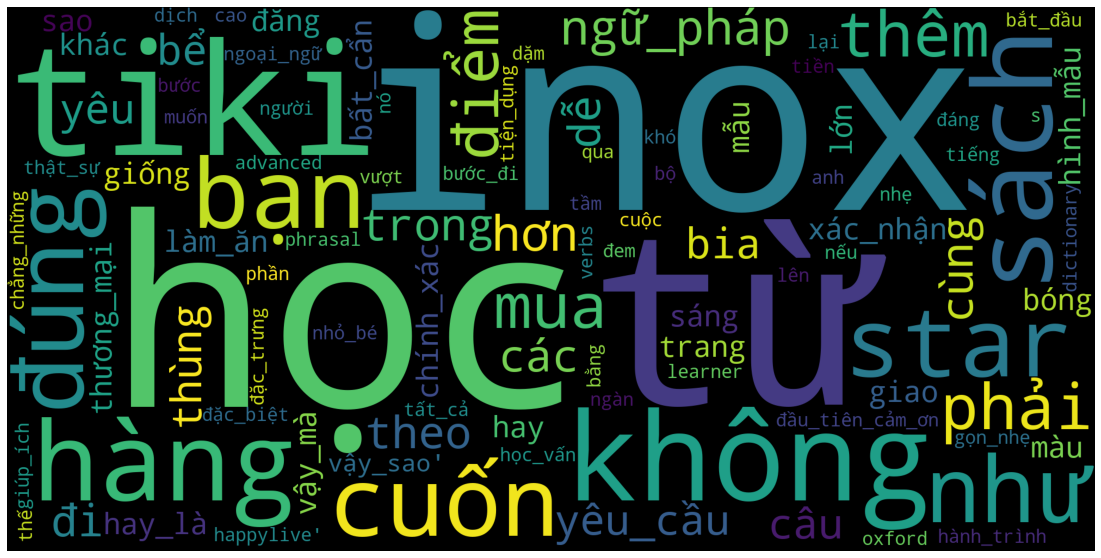

In [27]:
plt.figure(figsize=(20,10))
cloud = np.array(sentences).flatten()
word_cloud = wordcloud.WordCloud(max_words=100,background_color ="black",
                               width=2000,height=1000,mode="RGB").generate(str(cloud))
plt.axis("off")
plt.imshow(word_cloud)

In [28]:
plt.figure(figsize=(16,5))
counter=Counter(data['Content'])
most=counter.most_common()
x=[]
y=[]
for word,count in most[:10]:
    x.append(word)
    y.append(count)

<Figure size 1152x360 with 0 Axes>

<AxesSubplot:>

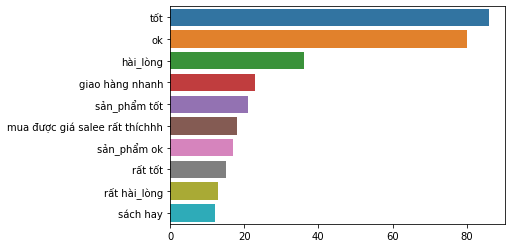

In [29]:
sns.barplot(x=y,y=x)

## Positive

In [30]:
data_pos = data[data['Rating'] == 1]
len(data_pos)

9570

In [31]:
sentences = []
for comment in data_pos['Content']:
    sent = []
    for word in comment.split(" ") :
        if (word not in stop_words) :
            if ("_" in word) or (word.isalpha() == True):
                sent.append(word)
    sentences.append(" ".join(sent))

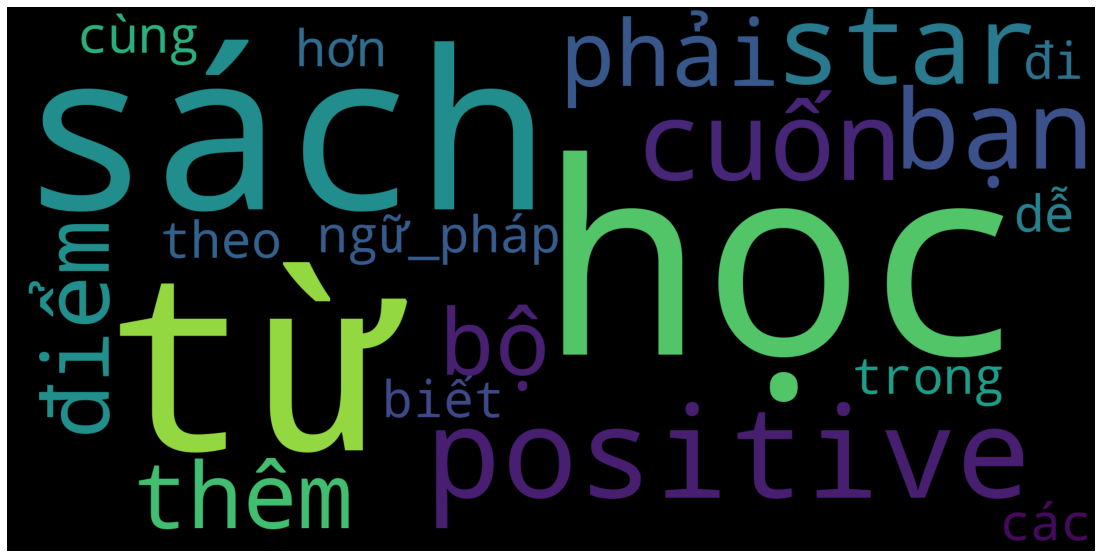

In [32]:
plt.figure(figsize=(20,10))
cloud = np.array(sentences).flatten()
word_cloud = wordcloud.WordCloud(max_words=20,background_color ="black",
                               width=2000,height=1000,mode="RGB").generate(str(cloud))
plt.axis("off")
plt.imshow(word_cloud)

In [33]:
counter=Counter(data_pos['Content'])
most=counter.most_common()
x=[]
y=[]
for word,count in most[:5]:
    x.append(word)
    y.append(count)

<AxesSubplot:>

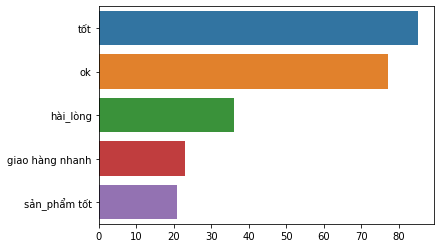

In [34]:
sns.barplot(x=y,y=x)

## Negative

In [35]:
data_neg = data[data['Rating'] == 0]
len(data_neg)

1699

In [36]:
sentences = []
for comment in data_neg['Content']:
    sent = []
    for word in comment.split(" ") :
        if (word not in stop_words) :
            if ("_" in word) or (word.isalpha() == True):
                sent.append(word)
    sentences.append(" ".join(sent))

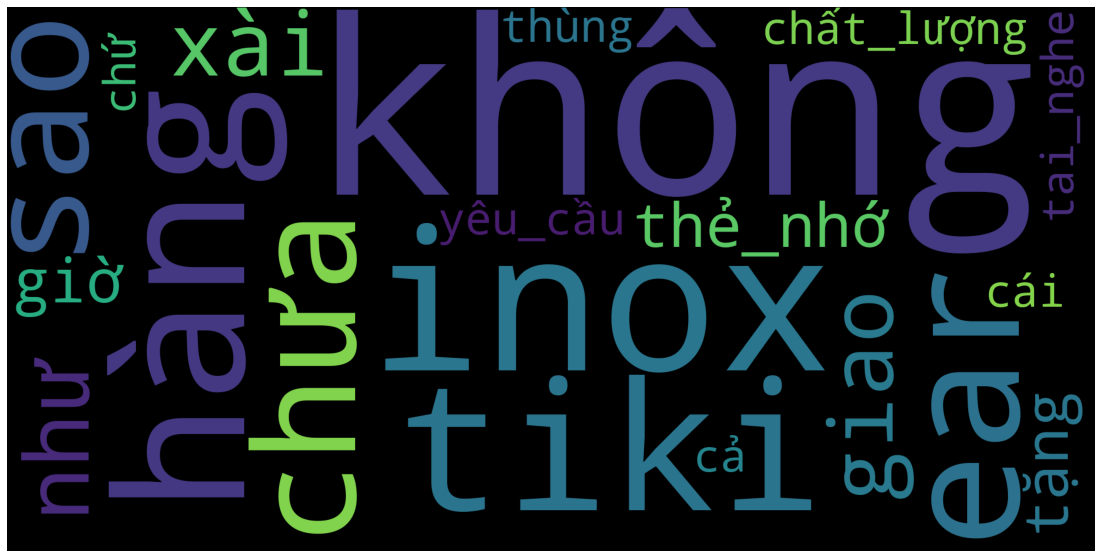

In [37]:
plt.figure(figsize=(20,10))
cloud = np.array(sentences).flatten()
word_cloud = wordcloud.WordCloud(max_words=20,background_color ="black",
                               width=2000,height=1000,mode="RGB").generate(str(cloud))
plt.axis("off")
plt.imshow(word_cloud)

In [38]:
counter=Counter(data_neg['Content'])
most=counter.most_common()
x=[]
y=[]
for word,count in most[:5]:
    x.append(word)
    y.append(count)

In [39]:
most[:5]

[('b√¨nh_th∆∞·ªùng', 3),
 ('ok', 3),
 ('giao h√†ng qu√° ch·∫≠m', 2),
 ('giao h√†ng qu√° l√¢u', 2),
 ('m√†u_s·∫Øc b√¨nh ƒëun n∆∞·ªõc ƒë·∫πp gi·ªëng h√¨nh tuy_nhi√™n ch·∫•t_li·ªáu kh√¥ng ·ªïn l·∫Øm ƒë·∫ø n·∫•u b·∫±ng nh·ª±a tr·∫Øng v·ªè b√¨nh b√™n ngo√†i nh·ª±a m√†u b√™n trong kim_lo·∫°i t·∫•t_c·∫£ ƒë·ªÅu m·ªèng c·∫ßm r·∫•t nh·∫π_tay c·∫£m_gi√°c gi·ªëng ƒëang c·∫ßm_ƒë·ªì_ch∆°i ch·ª© kh√¥ng ph·∫£i s·∫£n_ph·∫©m gia_d·ª•ng ƒë·ª£t n√†y tiki g√≥i h√†ng r·∫•t s∆°_s√†i kh√¥ng ƒë·∫πp kh√¥ng g·ªçn nh∆∞ th·ªùi_gian tr∆∞·ªõc n√≥i_chung m√¨nh c√≥ ch√∫t th·∫•t_v·ªçng v√¨ ƒë√¢y l√† h√†ng do tiki trading ph√¢n_ph·ªëi',
  2)]

In [40]:
sns.barplot(x=y,y=x)

<AxesSubplot:>

In [41]:
def remove_stopwords(input_text):
    whitelist = ["kh√¥ng", "kh√¥ng_th·ªÉ", "ch·∫≥ng"]
    words = input_text.split() 
    clean_words = [word for word in words if (word not in stop_words or word in whitelist) and len(word) > 1] 
    return " ".join(clean_words) 
data.Content = data.Content.apply(remove_stopwords)
data.head()

Rating                                            Content
0       1                                                   
1       1  cu·ªôc h√†nh_tr√¨nh ng√†n d·∫∑m ph·∫£i b·∫Øt_ƒë·∫ßu b·∫±ng b∆∞·ªõ...
2       1  star th·∫≠t_s·ª± ƒë√°ng ti·ªÅn mua cu·ªën s√°ch h·ªçc th√™m ...
3       1                                                   
4       1

In [42]:
data.loc[data['Content'].apply(lambda x : len(x) == 0),'Content'] = np.nan
data.dropna()['Rating'].value_counts()

1    9546
0    1698
Name: Rating, dtype: int64

In [43]:
data.dropna(inplace=True)
data.reset_index(inplace=True)

# 5. CLASSIFICATION 

## 5.1 Word2vec

In [44]:
input_size = 1000
max_features = 400

In [45]:
def read_questions(row,column_name):
    return gensim.utils.simple_preprocess(str(row[column_name]).encode('utf-8'))
    
documents = []
for index, row in data.iterrows():
    documents.append(read_questions(row, "Content"))

In [46]:
documents[0]

['cu·ªôc',
 'h√†nh_tr√¨nh',
 'ng√†n',
 'd·∫∑m',
 'ph·∫£i',
 'b·∫Øt_ƒë·∫ßu',
 'b·∫±ng',
 'b∆∞·ªõc_ƒëi',
 'nh·ªè_b√©',
 'ƒë·∫ßu_ti√™n_c·∫£m_∆°n',
 'b·ªô',
 's√°ch',
 'd·ªãch',
 'happylive']

In [47]:
w2v_model = Word2Vec(vector_size=300, window=10, min_count=2, sg=1, workers=10)

In [48]:
w2v_model.build_vocab(documents, progress_per=10000)

In [49]:
w2v_model.train(corpus_iterable=documents, total_examples=len(documents), epochs=8)

(1012121, 1316360)

In [50]:
w2v_model.wv.most_similar("ƒëi·ªán_tho·∫°i")

[('iphone', 0.7793577313423157),
 ('camera', 0.7507793307304382),
 ('samsung', 0.7498090863227844),
 ('h√†nh_tr√¨nh', 0.7448731064796448),
 ('ƒë·ªãnh_d·∫°ng', 0.7351607084274292),
 ('m∆∞·ª£t_m√†', 0.7321651577949524),
 ('tr√£i', 0.7307790517807007),
 ('c√πi', 0.7273775935173035),
 ('tho·∫°i', 0.7263613343238831),
 ('readwrite', 0.725723385810852)]

## 5.2 Sentiment Analysis

In [51]:
bow_vectorizer = CountVectorizer(max_features = max_features)
bow = bow_vectorizer.fit_transform(data['Content'])
bow.shape

(11244, 400)

In [52]:
train_bow = bow[:11600,:]

In [53]:
tokenized_review = data['Content'].apply(lambda x: x.split())

In [54]:
def word_vector(tokens, size):
    vec = np.zeros(size).reshape((1, size))
    count = 0
    for word in tokens:
        try:
            vec += w2v_model.wv[word].reshape((1, size))
            count += 1.
        except KeyError:  # handling the case where the token is not in vocabulary
            continue
    if count != 0:
        vec /= count
    return vec
wordvec_arrays = np.zeros((len(data), 300)) 
for i in range(len(data)):
    wordvec_arrays[i,:] = word_vector(tokenized_review[i], 300)
wordvec_df = pd.DataFrame(wordvec_arrays)
wordvec_df.shape

(11244, 300)

In [55]:
train_w2v = wordvec_df.iloc[:11600,:]
test_w2v = wordvec_df.iloc[11600:,:]

In [56]:
train_w2v

0         1         2         3         4         5         6    \
0      0.137071  0.087042 -0.004561  0.112710  0.034025 -0.007320  0.063200   
1      0.140682  0.009767  0.018990  0.105322  0.044345 -0.070417  0.045979   
2      0.068406  0.074010 -0.083788  0.029783  0.028737 -0.185997  0.064892   
3      0.148257  0.026920 -0.024794  0.051074 -0.028506 -0.073694 -0.037902   
4      0.264474  0.011788  0.017328  0.018236  0.141143 -0.201780  0.020854   
...         ...       ...       ...       ...       ...       ...       ...   
11239  0.206032  0.042219  0.171576  0.159767  0.093809 -0.136441  0.041967   
11240  0.146131  0.018453  0.117436  0.076923  0.038023 -0.145030  0.053373   
11241  0.135280 -0.007564  0.087291  0.081969  0.041002 -0.130463  0.063215   
11242  0.166242  0.061861  0.058010  0.139784  0.051468 -0.125267  0.069103   
11243  0.166242  0.061861  0.058010  0.139784  0.051468 -0.125267  0.069103   

            7         8         9    ...       290       291       292  \
0      0.179807 -0.015399  0.041472  ... -0.098180  0.130274  0.101652   
1      0.223946 -0.042374  0.145247  ... -0.079224  0.148095  0.097995   
2      0.231338 -0.126459  0.029821  ...  0.054298 -0.005946  0.054741   
3      0.287771 -0.118766 -0.054662  ...  0.014618  0.157759  0.130706   
4      0.311890 -0.057975  0.080771  ...  0.006196  0.176525  0.078152   
...         ...       ...       ...  ...       ...       ...       ...   
11239  0.359725 -0.278926  0.059743  ... -0.057867  0.173215  0.106805   
11240  0.325578 -0.124454 -0.058252  ... -0.026128  0.077946  0.091758   
11241  0.356788 -0.107806 -0.018317  ... -0.046957  0.073145  0.050216   
11242  0.314565 -0.193662 -0.009026  ... -0.000633  0.141340  0.100732   
11243  0.314565 -0.193662 -0.009026  ... -0.000633  0.141340  0.100732   

            293       294       295       296       297       298       299  
0     -0.046673  0.147216  0.079686 -0.023110 -0.129413 -0.005605  0.009112  
1     -0.122297  0.119563  0.095411 -0.018646 -0.116535  0.029951 -0.015341  
2     -0.154419  0.148034  0.141956 -0.091079  0.036904  0.038452 -0.166867  
3      0.100161  0.065278  0.133637 -0.128946  0.037419  0.087308 -0.126010  
4     -0.004975  0.051012  0.278554  0.043964 -0.014672  0.134438 -0.094118  
...         ...       ...       ...       ...       ...       ...       ...  
11239  0.029399  0.143434  0.187090 -0.004152 -0.069785  0.220767 -0.145900  
11240  0.050648  0.101456  0.184900 -0.041149 -0.027459  0.124547 -0.069723  
11241  0.034098  0.124323  0.181321 -0.040778 -0.068034  0.149423 -0.055779  
11242  0.029513  0.089934  0.118216 -0.026046 -0.003416  0.057378 -0.058620  
11243  0.029513  0.089934  0.118216 -0.026046 -0.003416  0.057378 -0.058620  

[11244 rows x 300 columns]

In [57]:
test_w2v

Empty DataFrame
Columns: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, ...]
Index: []

[0 rows x 300 columns]

In [58]:
X_train, X_test, Y_train, Y_test = train_test_split(train_bow, np.array(data['Rating']), random_state = 25, test_size = 0.3, stratify=np.array(data['Rating']))

# SMOTE: upsampling minority class

In [59]:
from imblearn.over_sampling import SVMSMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

In [60]:
import matplotlib.pyplot as plt

In [61]:
# Oversample and plot imbalanced dataset with SMOTE
from collections import Counter
counter = Counter(Y_train)
print(counter)

Counter({1: 6682, 0: 1188})


In [62]:
over = SVMSMOTE(sampling_strategy=0.3)
# under = RandomUnderSampler(sampling_strategy=0.6)
# steps = [('o', over), ('u', under)]
steps = [('o', over)]
pipeline = Pipeline(steps=steps)

In [63]:
X, Y = pipeline.fit_resample(X_train, Y_train)

In [64]:
Counter(Y)

Counter({0: 2004, 1: 6682})

In [65]:
Counter(Y)[0] / (Counter(Y)[0] + Counter(Y)[1])

0.23071609486530048

In [66]:
counter = Counter(Y_test)
print(counter)

Counter({1: 2864, 0: 510})


### Logistic Regression

In [67]:
LOR = LogisticRegression(solver='lbfgs',max_iter = 150) 

In [68]:
LOR.fit(X, Y) 

LOR.score(X_test, Y_test)

0.8838174273858921

In [69]:
y_pred = LOR.predict(X_test)
cm = confusion_matrix(Y_test, y_pred)
cm

array([[ 293,  217],
       [ 175, 2689]])

/home/dh2409/miniconda3/envs/pDL/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.



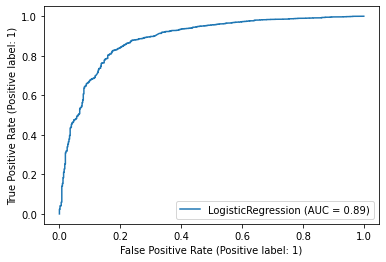

In [70]:
LOR_disp = plot_roc_curve(LOR, X_test, Y_test)
plt.show()

In [82]:


yhat = LOR.predict_proba(X_test)
# keep probabilities for the positive outcome only
yhat = yhat[:, 1]
# calculate roc curves
fpr, tpr, thresholds = roc_curve(Y_test, yhat)
gmeans = np.sqrt(tpr * (1-fpr))
ix = np.argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))

Best Threshold=0.802978, G-Mean=0.826


In [71]:
import pickle
pickle.dump(LOR, open('logistic.sav', 'wb'))

### Random Forest

In [72]:
RF = RandomForestClassifier(max_depth = 50, n_jobs = -1, random_state = 18, n_estimators = 140)
RF.fit(X, Y) 
RF.score(X_test, Y_test)

0.8876704208654416

In [73]:
y_pred = RF.predict(X_test)
cm = confusion_matrix(Y_test, y_pred)
cm

array([[ 258,  252],
       [ 127, 2737]])

In [74]:
RF_disp = plot_roc_curve(RF, X_test, Y_test)
plt.show()

/home/dh2409/miniconda3/envs/pDL/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.



In [83]:
yhat = RF.predict_proba(X_test)
# keep probabilities for the positive outcome only
yhat = yhat[:, 1]
# calculate roc curves
fpr, tpr, thresholds = roc_curve(Y_test, yhat)
gmeans = np.sqrt(tpr * (1-fpr))
ix = np.argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))

Best Threshold=0.731134, G-Mean=0.828


In [75]:
# filename = 'RF.sav'
# joblib.dump(RF, filename)
import pickle
pickle.dump(RF, open('RF.sav', 'wb'))

### Gradient Boosting

In [76]:
GB = GradientBoostingClassifier(random_state = 5, max_depth = 15)
GB.fit(X, Y)
GB.score(X_test, Y_test)

0.8796680497925311

In [77]:
y_pred = GB.predict(X_test)
cm = confusion_matrix(Y_test, y_pred)
cm

array([[ 253,  257],
       [ 149, 2715]])

In [78]:
GB_disp = plot_roc_curve(GB, X_test, Y_test)
plt.show()

/home/dh2409/miniconda3/envs/pDL/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.



In [84]:
yhat = GB.predict_proba(X_test)
# keep probabilities for the positive outcome only
yhat = yhat[:, 1]
# calculate roc curves
fpr, tpr, thresholds = roc_curve(Y_test, yhat)
gmeans = np.sqrt(tpr * (1-fpr))
ix = np.argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))

Best Threshold=0.872183, G-Mean=0.817


In [79]:
# filename = 'GB.sav'
# joblib.dump(GB, filename)
pickle.dump(GB, open('GB.sav', 'wb'))

# model = pickle.load(open('GB.sav', 'rb'))

In [210]:
import sklearn

# print('The nltk version is {}.'.format(nltk.__version__))
print('The scikit-learn version is {}.'.format(sklearn.__version__))

The scikit-learn version is 1.1.3.


## phoBert

In [2]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import re
import gensim
from vncorenlp import VnCoreNLP
import numpy as np

rdrsegmenter = VnCoreNLP("VnCoreNLP/VnCoreNLP-1.1.1.jar", annotators="wseg", max_heap_size='-Xmx500m') 

tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base")

model = AutoModelForSequenceClassification.from_pretrained("bdh240901/phoBert-BigData")

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [14]:
chars_to_ignore_regex = '[\,\?\.\!\-\;\:\"\\\n\(\)]'

def remove_special_characters(batch):
    batch = re.sub(chars_to_ignore_regex, '', batch)
    return batch

def remove_number_characters(batch):
    batch = re.sub("\d+",'', batch)
    return batch

def remove_any_special_left(batch):
    # Lo·∫°i b·ªè c√°c k√≠ t·ª± ƒë·∫∑c bi·ªát
    batch = gensim.utils.simple_preprocess(batch)
    batch = ' '.join(batch)
    # Sau khi lo·∫°i b·ªè k√≠ t·ª± ƒë·∫∑c bi·ªát th√¨ file s·∫Ω b·ªã m·∫•t nh·∫≠n di·ªán chu·ªói -> th√™m d·∫•u nh√°y v√†o chu·ªói
    return batch

def segment_text(text):
    batch = rdrsegmenter.tokenize(text)
    if len(batch) == 0:
        return ""
    else:
        return " ".join(batch[0]).strip()
    
def softmax(x):
    return(np.exp(x - np.max(x)) / np.exp(x - np.max(x)).sum())

def map_to_result(batch):
    print(batch)
    model.to("cpu")
    input_values = tokenizer(batch,return_tensors="pt", truncation=True).to("cpu")
    with torch.no_grad():
        logits = model(**input_values).logits
    # batch['label_id'] = torch.argmax(logits, dim=-1)
    # return batch
    return softmax(logits.numpy())[:,1]

def predict(text):
    text = segment_text((remove_any_special_left(remove_number_characters(remove_special_characters(text)))))
    model.to("cpu")
    input_values = tokenizer(text,return_tensors="pt").to("cpu")
    with torch.no_grad():
        logits = model(**input_values).logits
    # batch['label_id'] = torch.argmax(logits, dim=-1)
    # return batch
    return softmax(logits.numpy())[:,1]

In [15]:
test_df = pd.read_csv('test.csv')

In [16]:
test_df

Content  label
0     th·∫≠t_s·ª± r·∫•t ƒë√°ng ti·ªÅn khi mua cu·ªën s√°ch n√†y ƒë·ªÉ...      1
1                     shipper giao h∆°i mu·ªôn t√≠ th√¥i nha      1
2     xinh x·ªãn d·ªÖ d√πng giao h√†ng nhanh gi√° r·∫ª kho·∫ª th√¢n      1
3     h√†ng okey nha m·ªçi ng∆∞·ªùi b√∫t m·ªãn v√† kh√¥ng b·ªã le...      1
4     t√∫i to b√™n trong kh√¥ng chia nh·ªè n√™n b·∫£o_qu·∫£n h...      1
...                                                 ...    ...
3362  v·ª´a nh·∫≠n th·∫ª nh·ªõ ƒë√£ l·∫Øp th·ª≠ v√†o m√°y v√† ƒë·ªÅu kh√¥...      0
3363  vui_l√≤ng ki·ªÉm_tra l·∫°i gi√∫p m√¨nhnh∆∞ ban_ƒë·∫ßu mua...      0
3364  x√†i m·ªõi dc th√°ng m√† ƒë·ªì b·∫≠t b√¨nh n∆∞·ªõc b·ªã h∆∞ rb·∫•...      0
3365  xe m·ªõi nguy√™n th√πng nh∆∞ng thi·∫øu ·ªëc kh√¥ng l·∫Øp c...      0
3366  y√™u_c·∫ßu tiki l√†m_vi·ªác v·ªõi b√™n v·∫≠n_chuy·ªÉn giao ...      0

[3367 rows x 2 columns]

In [17]:
test_df['predict'] = test_df['Content'].apply(map_to_result)

th·∫≠t_s·ª± r·∫•t ƒë√°ng ti·ªÅn khi mua cu·ªën s√°ch n√†y ƒë·ªÉ h·ªçc th√™m ngo·∫°i_ng·ªØ ƒë·∫∑c_bi·ªát l√† ph·∫ßn phrasal verbs v√¨ n√≥ l√† ƒëi·ªÉm ng·ªØ_ph√°p ƒë·∫∑c_tr∆∞ng v√† r·∫•t kh√≥ c·ªßa ti·∫øng anh m√† t·∫•t_c·∫£ ng∆∞·ªùi h·ªçc ph·∫£i v∆∞·ª£t qua n·∫øu mu·ªën b∆∞·ªõc l√™n m·ªôt t·∫ßm cao h∆°n trong h·ªçc_v·∫•n v√† cu·ªën s√°ch n√†y gi√∫p_√≠ch cho m√¨nh r·∫•t nhi·ªÅu ch·∫≥ng_nh·ªØng th·∫ø l·∫°i c√≤n g·ªçn_nh·∫π v√† ti·ªán_d·ª•ng ƒë·ªÉ ƒëem theo khi ƒëi h·ªçc nh·∫π h∆°n cu·ªën oxford advanced learner dictionary n·ªôi_dung s√°ch bao_g·ªìm t·ª´ ch√≠nh t·ª´ ƒëi c√πng v·ªõi nh·ªØng gi·ªõi_t·ª´ n√†o v√† ƒëi·ªÉm ng·ªØ_ph√°p theo c√πng c√≥ phi√™n_√¢m c√≥ t·ª´_ƒë·ªìng_nghƒ©a ƒë·ªÉ b·∫°n bi·∫øt khi n√†o n√™n d√πng t·ª´ n√†o l√† ƒë√∫ng v√† c√≥ th√™m v√≠_d·ª• ƒë·ªÉ d·ªÖ h·ªçc d·ªÖ nh·ªõ c≈©ng nh∆∞ m·ªôt_s·ªë l·ªùi khuy√™n h·ªØu_√≠ch trong vi·ªác h·ªçc v√† c√≤n nhi·ªÅu ƒëi·ªÅu th√∫_v·ªã m√† c√°c b·∫°n c√≥_th·ªÉ t·ª± kh√°m_ph√° ch√∫c c√°c b·∫°n h·ªçc vui
shipper giao h∆°i mu·ªôn t√≠ th√¥i n

b·ªçn m√®o r·∫•t th√≠ch
b√∫t_bi n√†y r·∫•t ƒë·∫πp v√† d·ªÖ_th∆∞∆°ng v√† ƒë√∫ng nh∆∞ nh·ªØng g√¨ qu·∫£ng_c√°o
b√∫t_bi vi·∫øt r·∫•t ƒë·ªÅu m·ª±c r·∫•t th√≠ch m√¨nh mua v·ªÅ ƒë·ªÉ th∆∞·ªüng cho h·ªçc_sinh c√°c ch√°u r·∫•t th√≠ch
b√∫t_ch√¨ d√πng ·ªïn ch·∫•t_l∆∞·ª£ng tiki tranding th√¨ kh·ªèi ph·∫£i b√†n ng√≤i ra tr∆°n ƒë·ªÅu d·ªÖ s·ª≠_d·ª•ng
b√∫t_ch√¨ x√†i r·∫•t ·ªïn vi·∫øt ch·ªØ ƒë·ªÅu v√† s·∫Øc n√©t r·∫•t th√≠ch th∆∞∆°ng_hi·ªáu pentel v√¨ x√†i r·∫•t t·ªët t·ª´ l√∫c c√≤n h·ªçc c·∫•p
b√∫t ch√≠nh h√£ng m·ª±c ra ƒë·ªÅu ƒë·∫πp r·∫•t h√†i_l√≤ng v·ªÅ c√°ch giao h√†ng c·ªßa tiki
b√∫t c·ª±c_k√¨ ƒë√°ng iuuu lu√¥n ƒë·ªß m√†u n√® l·∫°i c√≤n r·∫ª n·ªØa
b√∫t c·ª±c_k√¨ d·ªÖ_th∆∞∆°ng m·ª±c √™mvi·∫øt ƒë·∫πp s·∫Ω ·ªßng_h·ªô shop
b√∫t d·ªÖ_th∆∞∆°ng c·ª±c m·ª±c ƒë·ªÅu m√†u
b√∫t d·ªÖ_th∆∞∆°ng l·∫Øm giao h√†ng c·ª±c nhanh
b√∫t d·ªÖ_th∆∞∆°ng nh∆∞ qu·∫£ng_c√°o n√® giao h√†ng nhanh c·∫£m_∆°n shop v√† tiki nh√©
b√∫t d·ªÖ_th∆∞∆°ng m·ª±c ra ƒë·ªÅu c√°c b√© nh√† m√¨nh r·∫•t th√≠ch
b√∫t ƒë·∫πp m·ª±c ƒë·∫≠m ƒë·ªÅu em 

ch·∫•t_l∆∞·ª£ng t·ªët d√πng nh·∫π ƒë∆°n_gi·∫£n h∆°n c√°c xoong th√¥ng_th∆∞·ªùng
ch√¢ l∆∞∆° ng tuy√™ ha ng h√¥ nhi√™ cho shop
ch·∫•t_l∆∞·ª£ng tuy·ªát_v·ªùi m√†u r√µ n√©t r·∫•t h√†i_l√≤ng v·ªõi sp n√†y
ch·∫•t_l∆∞·ª£ng v√† uy_t√≠n c·ªßa t·ª´_ƒëi·ªÉn oxford th√¨ kh·ªèi ph·∫£i b√†n b·∫•t_c·ª© ai mu·ªën h·ªçc t·ªët ti·∫øng anh ƒë·ªÅu n√™n ƒë·∫ßu_t∆∞ cu·ªën t·ª´_ƒëi·ªÉn oxford ƒë·ªÉ h·ªçc t·ªët th√¨ bi·∫øt nhi·ªÅu t·ª´_v·ª±ng l√† ch∆∞a ƒë·ªß ch√∫ng_ta c·∫ßn ph·∫£i_bi·∫øt c√°ch d√πng ƒë√∫ng collocation theo ng·ªØ_c·∫£nh oxford collocations dictionary r·∫•t h·ªØu_√≠ch trong vi·ªác cung_c·∫•p c√°c k·∫øt_h·ª£p t·ª´ ƒë·ªÉ s·ª≠_d·ª•ng trong vƒÉn vi·∫øt v√† n√≥i sao cho ƒë√∫ng chu·∫©n_m·ª±c t·ª´_ƒëi·ªÉn d√†y v√† n·∫∑ng c√≥ k√®m theo cd ƒë·ªÉ c√†i_ƒë·∫∑t tr√™n m√°y_t√≠nh ƒë·ªÉ s·ª≠_d·ª•ng d·ªÖ_d√†ng h∆°n
ch·∫•t_l∆∞·ª£ng v·ªÅ n·ªôi_dung c·∫£ v·ªÅ ngo·∫°i_h√¨nh ph·∫£i m·ªõi ƒë√∫ng tks happylive team
chats l∆∞·ª£ng b√∫t nh·∫≠t pentel r·∫•t t·ªët m√¨nh d√πng d√≤ng n√†y t·ª´ c·∫•p
ch√°u m√¨nh r·∫•t th√≠ch

cu·ªën t·ª´_ƒëi·ªÉn n√†y c√≥_th·ªÉ xem nh∆∞ l√† ng∆∞·ªùi b·∫°n ƒë·ªìng_h√†nh c·∫ßn_thi·∫øt l√† b·∫•t_k√¨ ai h·ªçc ti·∫øng anh v·ªõi m·ª©c_ƒë·ªô ch√≠nh_x√°c cao d·ªÖ hi·ªÉu v√† nh·ªè g·ªçn m√¨nh ƒë√£ s·ª≠_d·ª•ng n√≥ t·ª´ nƒÉm l·ªõp t·ªõi t·∫≠n b√¢y_gi·ªù khi t·ªët_nghi·ªáp ƒë·∫°i_h·ªçc v√† ƒëi l√†m m√¨nh ƒë√°nh_gi√° cao v·ªÅ phrasal verb m·∫∑c_d√π t·ª´_ƒëi·ªÉn nh·ªè c·∫ßm tay nh∆∞ng l·∫°i tr√¨nh_b√†y h·∫øt_s·ª©c ƒë·∫ßy_ƒë·ªß v·ªÅ kho·∫£n n√†y v√¨ l√† t·ª´_ƒëi·ªÉn anh anh n√™n c√≥_th·ªÉ d·ªÖ tra t·ª´_ƒë·ªìng_nghƒ©a t·ª´_ƒëi·ªÉn ƒë∆∞·ª£c tr√¨nh_b√†y ƒë·∫πp m√†u ch·ªØ xanh d·ªÖ tra ch·∫•t_l∆∞·ª£ng gi·∫•y t·ªët
cu·ªën t·ª´_ƒëi·ªÉn n√†y r·∫•t tuy·ªát gi·∫£i_th√≠ch r√µ_r√†ng c√≥ family words ƒë·∫ßy_ƒë·ªß
cu·ªën t·ª´_ƒëi·ªÉn r·∫•t hay d·ªÖ s·ª≠_d·ª•ng c√≥_th·ªÉ_tra xem danh_t·ª´ ƒë·∫øm ƒë∆∞·ª£c hay kh√¥ng ƒë·∫øm ƒë∆∞·ª£c c√°i form kh√°c c·ªßa t·ª´ nh∆∞ng m√¨nh nghƒ© ch·ªâ nh·ªØng b·∫°n ƒë√£ c√≥ m·ªôt v·ªën t·ª´ cƒÉn b·∫£n m·ªõi n√™n mua cu·ªën n√†y khi ƒë·ªçc ƒë·ªãnh_nghƒ©a th√¨ m·ªõi hi·ªÉu ƒ

ƒëi·ªán_tho·∫°i ch√≠nh h√£ng t·ªët m∆∞·ª£t_m√† gi√° r·∫ª giao h√†ng nhanh
ƒëi·ªán_tho·∫°i ƒë·∫πp gi√°_c·∫£ h·ª£p_l√Ω nh√¢n_vi√™n giao h√†ng th√¢n_thi·ªán
ƒëi·ªán_tho·∫°i d√πng ok nh·ªù shop k√≠ch_ho·∫°t b·∫£o_h√†nh gi√∫p
ƒëi·ªán_tho·∫°i r·∫•t v·ª´a gi√° t·ªët n·ªØa r·∫•t th√≠ch
ƒëi·ªán_tho·∫°i t·ªët gi√° h·ª£p_l√Ω n√™n mua
ƒë·ªânh lu√¥n
ƒëo ng∆∞·ªùi v√† l·∫≠p l·∫°i th·∫•y chu·∫©n l·∫Øm m√† bi·∫øt_bao h√†nh nƒÉm c√≥ ƒë√∫ng hii
ƒë·ªì_ƒÉn cho m√®o tr∆∞·ªüng_th√†nh meo v·ªã c√°_ng·ª´ kg ok t·ªët
ƒë·ªì_ƒÉn cho m√®o tr∆∞·ªüng_th√†nh meo v·ªã c√°_thu kgƒë·ªì ƒÉn cho m√®o tr∆∞·ªüng_th√†nh meo v·ªã c√°_thu kgƒë·ªì ƒÉn cho m√®o tr∆∞·ªüng_th√†nh meo v·ªã c√°_thu kgƒë·ªì ƒÉn cho m√®o tr∆∞·ªüng_th√†nh meo v·ªã c√°_thu kgƒë·ªì ƒÉn cho m√®o tr∆∞·ªüng_th√†nh meo v·ªã c√°_thu kgƒë·ªì ƒÉn cho m√®o tr∆∞·ªüng_th√†nh meo v·ªã c√°_thu kg
ƒë·ªì_ƒÉn cho m√®o tr∆∞·ªüng_th√†nh meo v·ªã h·∫£i_s·∫£n kg ƒë·ªì_ƒÉn cho m√®o tr∆∞·ªüng_th√†nh meo v·ªã h·∫£i_s·∫£n kg ƒë·ªì_ƒÉn cho m√®o tr∆∞·ªüng_th√†nh meo v·ªã h·∫£i_s

game vui_v·∫ª nh·∫π_nh√†ng d·ªÖ ch∆°i n·∫øu c√≥ b·∫°n_b√® l·∫ßy_l·ªôi hay b√≥p nhau th√¨ n√™n tham_kh·∫£o th√™m game si√™u th√∫ ng√¢n_h√† s·∫Øp ra_m·∫Øt n·ªØa
gel ch·∫•m m·ª•n ho·∫°t_ƒë·ªông v√¥_c√πng hi·ªáu_qu·∫£ ch·∫•m l·∫ßn l√† m·ª•n gi·∫£m s∆∞ng t·∫•y nhanh_ch√≥ng
gel ƒë·∫∑c nhanh kh√¥ d·ªÖ l·ªôt
gel trong su·ªët x√†i th·∫•y hi·ªáu_qu·∫£ l√† d·ªãu m·ª•n ·ª≠ng v√† m·ªõi n·∫∑n c·ªßa m√¨h r·∫•t th√≠ch
gia
gi√°_c·∫£ h·ª£p_l√≠ b√∫t vi·∫øt t·ªët kh√¥ng b·ªã t·∫Øc
gi√°_c·∫£ h·ª£p_l√Ω h∆°n samsung b·ªè v√†o camera h√†nh_tr√¨nh ch·∫°y t√≠t
gi√°_c·∫£ h·ª£p_l√Ω t√¥i lu√¥n tin_t∆∞·ªüng tiki m·ªói khi mua h√†ng th·∫ßy_gi√°o guitar v≈© tr·ªçng_long
gi√°_c·∫£ h·ª£p_l√Ω giao h√†ng nhanh h√†ng th√¨ ƒë√≥ng_g√≥i r·∫•t k·ªπ_c√†ng lu√¥n ch·ªëng s·ªëc ch·ªëng va_ƒë·∫≠p m·∫•y l·ªõp lu√¥n c√≤n ghi k√®m h√†ng d·ªÖ v·ª° b√™n ngo√†i n·ªØa s·∫£n_ph·∫©m ƒë·∫πp n·∫•u nhanh ƒë·ªô b·ªÅn th√¨ ch∆∞a bi·∫øt th·∫ø_n√†o thui t·ªët
gi√°_c·∫£ h·ª£p_l√Ω giao h√†ng nhanh h√†ng th√¨ ƒë√≥ng_g√≥i r·∫•t k·ªπ_c√†ng lu√¥n ch·ªë

giao hang nhanh tot va leco ƒëoeu nv giao ch∆∞a ranh ƒë∆∞∆°ng
giao h√†ng nhanh v√† ch·∫•t_l∆∞·ª£ng
giao h√†ng nhanh bao_b√¨ ƒë√≥ng_g√≥i ƒë·∫πp h√†ng s·∫£n_xu·∫•t t·∫°i malaysia ch∆∞a s·ª≠_d·ª•ng nh∆∞ng nh√¨n r·∫•t ·ªïn
giao h√†ng nhanh bia u·ªëng ngon
giao h√†ng nhanh b√∫t ƒë·∫πp kh√¥ng b·ªã l·ªói
giao h√†ng nhanh b√∫t nhi·ªÅu h√¨nh d·ªÖ_th∆∞∆°ng c·∫£m_∆°n shop c·∫£m_∆°n tiki
giao h√†ng nhanh ch·∫•t_l∆∞·ª£ng b√†i ok
giao h√†ng nhanh ch·∫•t_l∆∞·ª£ng cao t√¥i r·∫•t h√†i_l√≤ng v·ªÅ s·∫£n_ph·∫©m c·ªßa b·∫°n bia tiger cho sao
giao h√†ng nhanh ch·∫•t_l∆∞·ª£ng s·∫£n_ph·∫©m t·ªët r·∫•t h√†i_l√≤ng v·ªÅ tiki
giao h√†ng nhanh ch·∫•t_l∆∞·ª£ng s·∫£n_ph·∫©m tuy·ªát_v·ªùi
giao ha ng nhanh cho ƒë∆∞∆° ca me con va me l∆° ƒÉn
giao h√†ng nhanh ch∆∞a d√πng n√™n ch∆∞a bi·∫øt th·∫ª ntn
giao ha ng nhanh ƒëƒÉ h√¥ ƒë√™m ma h√¥m sau ƒëa nh√¢ ƒë∆∞∆° ƒëo ng go c√¢ th√¢ nh√¢n_vi√™n giao ha ng d√™ th∆∞∆°ng sa ph√¢ ƒëe s∆∞ du ng r√¢ t√¥ ƒëa ng ti√™ trong t√¢ gia sao
giao h√†ng nhanh ƒë√≥ng_g√≥i c·∫©n_th·∫≠n
giao h√†

good
good book
good good t·ªët t·ªët t·ªët ok ok
good job
good product ƒë·∫πp d·ªÖ_th∆∞∆°ng v√† s·∫Ω ti·∫øp_t·ª•c ·ªßng_h·ªô
good t·ªët l·∫Øm giao h√†ng nhanh sao nha
good
good
good
good h√†ng ch√≠nh h√£ngthanks shop
hai_long
h√†i_l√≤ng
h√†i_l√≤ng
h√†i_l√≤ng
h√†i_l√≤ng
h√†i_l√≤ng
h√†i_l√≤ng
h√†i_l√≤ng
h√†i_l√≤ng
h√†i_l√≤ng
h√†i_l√≤ng s·∫Ω ·ªßng_h·ªô ti·∫øp giao h√†ng nhanh
h√†i_l√≤ng v·ªÅ s·∫£n_ph·∫©m n·∫ßy
h√†i_l√≤ng v·ªÅ s·∫£n_ph·∫©m nh·∫≠n ƒë∆∞·ª£c ƒë√∫ng quy_c√°ch m·∫´u_m√£
h√†i_l√≤ng v·ªÅ s·∫£n_ph·∫©m trong m·ª©c gi√° n√†y ki·ªÉu d√¢y d√π_cho c·∫£m_gi√°c ch·∫Øc_ch·∫Øn d·ªãch_v·ª• ƒë√≥ng_g√≥i c·∫©n_th·∫≠n
h√†i_l√≤ng v·ªÅ s·∫£n_ph·∫©m
h√†i_l√≤ng v·ªÅ s·∫£n ph·∫©m·∫•m d·ªÖ s·ª≠_d·ª•ng c√≥ nhi·ªÅu ch·∫ø_ƒë·ªô s√¥i
h√†i_l√≤ng v·ªõi ch·∫•t_l∆∞·ª£ng giao h√†ng nhanh ƒë√≥ng_g√≥i kƒ©
h√†i_l√≤ng v·ªõi s·∫£n_ph·∫©m b√™n tiki
h√†i_l√≤ng v·ªõi s·∫£n_ph·∫©m ƒë√£ mua ch·∫•t_l∆∞·ª£ng t·ªët ƒë·ªì m·ªõi ƒë·∫£m_b·∫£o kh√¥ng g·∫∑p c√°c v·∫•n_ƒë·ªÅ g√¨ khi·∫øn m√¨nh th·∫•t_v·ªçng ch∆°i c≈©ng r·∫•t vui

h√†ng nguy√™n seal d√πng m∆∞·ª£t giao h√†ng nhanh cam kh√¥ng ƒë·∫πp cho l·∫Øm nh∆∞ng so v·ªõi gi√° th√¨ qu√° t·ªët
h√†ng nguy√™n seal giao tiki now nhanh gi√° ok ch·∫•t_l∆∞·ª£ng th√¨ h√†ng ƒëi·ªán_t·ª≠ h√™n xui th√¥i
h√†ng nguy√™n sell r·∫•t ok nho tiki kick ho·∫°t b·∫£o_h√†nh gi√πm lu√¥n
h√†ng nh√¨n ƒë·∫πp ƒë·ªó n∆∞·ªõc ƒë·∫ßy ·∫•m ph√∫t l√† s√¥i d√πng c·∫£ tu·∫ßn nay r·ªìi m·ªõi ƒë√°nh_gi√° hi·ªán_t·∫°i ch∆∞a ph√°t_sinh v·∫•n_ƒë·ªÅ g√¨ c·∫£ nh√¢n_vi√™n giao h√†ng t·ªët ch·ªù d√πng th·ª≠ th·∫•y ·ªïn r·ªìi m·ªõi ƒëi
h√†ng nh∆∞ h√¨nh ƒë√≥ng_g√≥i k·ªπ h·∫°n_d√πng d√†i r·∫•t ∆∞ng
h√†ng nh∆∞ m√¥_t·∫£ ch√≠nh h√£ng
h√†ng ok ƒë√∫ng lo·∫°i ƒë√£ ƒë·∫∑t
h√†ng ok l·∫Øm
h√†ng ok nguy√™n seal nh√© b√†_con
hang ok cam on dhop nhe
h√†ng ok ƒëc mua k√®m qu√† c·∫£m_∆°n tiki
h√†ng ok s·∫£n_ph·∫©m gi·ªëng m√¥_t·∫£ c·∫£m_gi√°c r·∫•t an_to√†n
h√†ng ok x√†i r·∫•t ·ªïn mua h√†ng philip n√™n y√™n_t√¢m ƒë√£ d√πng l·∫ßn ·ªïn
h√†ng ·ªïn ƒë√≥ng_g√≥i t·ªët nh∆∞ng ko th·∫•y c√°i g√≥i t·∫∑ng kho√° nhi·∫øp_·∫£nh ƒë√¢

khi n·∫•u n∆∞·ªõc c√≥ m√†u xanh ƒë·∫πp d·ªÖ d√πng n·∫•u n∆∞·ªõc nhanh b√¨nh thuye tinh trong nh∆∞ng c·∫ßm_ch·∫Øc ch·∫Øn
khi t√¥i nh·∫≠n ƒë∆∞·ª£c cu·ªën oxford pocket n√†y t√¥i r·∫•t th√≠ch v√¨ n√≥ r·∫•t ti·ªán_l·ª£i c√≥_th·ªÉ mang ƒëi b·∫•t_k√¨ n∆°i ƒë√¢u pocket ch·ª©a g·∫ßn nh∆∞ ƒë·∫ßy_ƒë·ªß t·∫•t_c·∫£ c√°c t·ª´ v√† c√°c v√≠_d·ª• r·∫•t l√† h·ªØu_√≠ch trang b√¨a ƒë∆∞·ª£c thi·∫øt_k·∫ø v·ªõi t√¥ng m√†u xanh nh√¨n v√†o r·∫•t d·ªÖ_ch·ªãu v√† sang_tr·ªçng ƒë∆∞·ª£c ƒë√°nh_d·∫•u v·ªõi c√°c ch·ªØ_c√°i r·∫•t d·ªÖ_d√†ng trong vi·ªác tra t·ª´ v·ªõi m·ª©c gi√°_nh∆∞ th·∫ø_th√¨ pocket ƒë√£ kh√¥ng l√†m th·∫•t_v·ªçng ng∆∞·ªùi mua ƒë·ªëi_v·ªõi nh·ªØng_ai ƒëang h·ªçc ti·∫øng anh th√¨ ƒë√¢y qu·∫£_th·ª±c l√† m·ªôt quy·ªÉn t·ª´_ƒëi·ªÉn c·∫ßn_thi·∫øt
kh√¥ng bi·∫øt b√© c√≥ th√≠ch ƒÉn nh∆∞ nh·ªØng lo·∫°i kh√°c kh√¥ng nh∆∞ng_m√† giao h√†ng nhanh s·∫£n_ph·∫©m date xa n√™n h√†i_l√≤ng
kh√¥ng bi·∫øt con_em ƒëi ƒë√¢u l√¥i v·ªÅ quy·ªÉn s√°ch xong n√≥i b√† ƒë·ªçc ƒëi ch·ª© th·∫•y b√† ch∆∞a bi·∫øt qu·∫£n_l√Ω ti·ªÅn_b·

m√°y ƒëo t·ªët ch√≠nh_x√°c d·ªÖ s·ª≠_d·ª•ng
m√°y ƒëo t·ªët mua ngay ƒë·ª£t sale r·∫ª m√†_c√≤n ƒë∆∞·ª£c t·∫∑ng qu√† si√™u to n·ªØa giao h√†ng th√¨ c·ª±c nhanh m·ªõi ƒë·∫∑t t·ªëi_qua m√† t·ªëi mai nh·∫≠n ƒë∆∞·ª£c r·ªìi c√°m_∆°n tiki nhi·ªÅu
m√°y ƒëun nhanh b·ªÅn ƒë·∫πp v√† ƒë·∫∑c_bi·ªát l√† ko c√≥ m√πi h√¥i d√πng r·∫•t th√≠ch
m√°y d√πng ch√≠p ch·∫°y r·∫•t m∆∞·ª£t pin r·∫•t tr√¢u mua ƒë·ª£t gi·∫£m_gi√° c√≤n trk b·∫£n ram b·ªô_nh·ªõ
m√°y d√πng kh√° m∆∞·ª£t h√†ng nguy√™n ƒëai nguy√™n ki·ªán kh√¥ng m·ªôt l·ªói g√¨ mua c√°i bao da b·ªè v√¥ n·ªØa l√† ngon
m√°y d√πng m∆∞·ª£t m√†c√≤n pin tr√¢u ƒë·∫øn ƒë√¢u ph·∫£i d√πng th·ª≠ xem bao_l√¢u m·ªõi s·∫°c ƒë√£ h√†ng ch√≠nh h√£ng digiword
m√°y d√πng m∆∞·ª£t ch∆∞a c√≥ g√¨ ƒë·ªÉ ph√†n_n√†n tiki giao h√†ng nhanh ƒë√≥ng_g√≥i c·∫©n_th·∫≠n v√† an_to√†n
m√°y d√πng t·ªët ƒëo nhanh v√† chu·∫©n ƒë√¢y l√† l·∫ßn m√¨nh mua m√°y tr√™n tiki r·ªìi
m√°y d√πng t·ªët nha mn r·∫Ω h∆°n gi√° ch√≠nh h√£ng m√°y n√†y x√°ch tay b·∫£n za
m√°y d√πng t·ªët ƒëo ch√≠nh_x√°c tr∆∞·ªõc

m√¨nh ƒë√£ mua v√† s·ª≠_d·ª•ng ƒë∆∞·ª£c m·ªôt th·ªùi_gian n·ªìi d√πng r·∫•t th√≠ch n·∫•u ch√°o h·∫ßm x∆∞∆°ng hay n·∫•u x√¥i ƒë·ªÅu ngon mua ƒë·ª£t km gi√° t·ªët n√™n c·∫£m_th·∫•y h√†i_l√≤ng
m√¨nh ƒë√£ nh·∫≠n ƒëc h√†ng sp r·∫•t t·ªët m√¨nh s·∫Ω ·ªßng_h·ªô shop
m√¨nh ƒë√£ nh·∫≠n ƒë∆∞·ª£c h√†ng v√† r·∫•t h√†i_l√≤ng v·ªÅ s·∫£n_ph·∫©m ch·∫•t_l∆∞·ª£ng d·ªãch_v·ª• c·ªßa tiki nh·ªù tiki k√≠ch_ho·∫°t b·∫£o_h√†nh gi√∫p m√¨nh nh√© v√¨ m√¨nh ƒë√£ t·ª± g·ª≠i m√£ imei v·ªÅ nh∆∞ng m√£i m√† kh√¥ng th·∫•y ph·∫£n_h·ªìi khi check tr√™n website c·ªßa samsung th√¨ v·∫´n th·∫•y l√† ƒëi·ªán_tho·∫°i c·ªßa m√¨nh ch∆∞a ƒë∆∞·ª£c k√≠ch_ho·∫°t b·∫£o_h√†nh tiki h·ªó_tr·ª£ k√≠ch_ho·∫°t b·∫£o_h√†nh gi√∫p m√¨nh nh√© c·∫£m_∆°n tiki nhi·ªÅu
m√¨nh ƒë√£ nh·∫≠n s·∫£n_ph·∫©m ƒë·∫∑t_h√†ng t·ªëi th·ª© s√°ng ch·ªß_nh·∫≠t ƒë√£ nh·∫≠n h√†ng s·∫£n_ph·∫©m nh∆∞ m·∫´u v·ªÅ h√¨nh_th·ª©c th√¨ v·ªõi t·∫ßm gi√° ch∆∞a ƒë·∫øn tr th√¨ r·∫•t l√† ok m√†n_h√¨nh l·ªõn m√¨nh mua m√†u tr·∫Øng ng·ªçc_trai n√™n kh√° ƒë·∫πp giao h√†ng nhanh ch∆∞a s

m√¨nh mua t·∫∑ng m·∫πth·∫•y r·∫•t tuy·ªát_v·ªùi v√¨ b√† d·ªÖ s·ª≠ d·ª•nggi√° l·∫°i h·ª£p_l√Ω khi mua tr√™n tiki r·∫ª h∆°n th·ªã_tr∆∞·ªùng
minh mua v√† th·∫•y ƒëo t·ªët mu·ªën mua b·ªô s·∫°c cho m√°y mong shop h·ªó_tr·ª£
m√¨nh mua v·ªÅ cho m·∫•y ƒë∆∞a h·ªçc_tr√≤ to√†n_b·ªô l√† m·ª±c ƒëen ch·∫•t_l∆∞·ª£ng ok
m√¨nh mu·ªën mua ƒëƒ©a c√†i_ƒë·∫∑t ko mua s√°ch c√≥ ƒë∆∞·ª£c ko v√¨ ƒëƒ©a m√¨nh ƒë√£ h·∫øt h·∫°n nƒÉm
m√¨nh nh·∫≠n ƒë∆∞·ª£c b·ªô m√†u h·ªìng b√∫t ƒëen b√∫t vi·∫øt ƒë·∫πp nh∆∞ng mau h·∫øt_m·ª±c
m√¨nh order th·ª© th·ª© tu·∫ßn sau ƒë√≥ nh·∫≠n ƒë∆∞·ª£c ·∫•m ƒëun nhanh √™m kh√¥ng g√¢y ·ªìn th√¢n ·∫•m khi ƒëun r·∫•t n√≥ng ƒë·∫•y b·∫°n n√†o nh√† c√≥ tr·∫ª_em nh·ªõ tr√°nh xa t·∫ßm tay t·ª•i nh·ªè ƒë√≥ng_g√≥i ch·∫Øc_ch·∫Øn b·∫£o_h√†nh r√µ_r√†ng t·ªët
m√¨nh r·∫•t h√†i_l√≤ng ch∆°i r·∫•t vui b·∫£n_ƒë·ªì si√™u ƒë·∫πp
m√¨nh r·∫•t th√≠ch ch∆°i r·∫•t vui nh∆∞ng ph·∫£i ch∆°i c√πng v·ªõi nhau t·ª´ cho ƒë·∫øn b·∫°n
m√¨nh r·∫•t ∆∞ng v·ªÅ ƒë√≥ng_g√≥i m·∫´u_m√£ c·ªßa sp ch·ª•p ƒëk ƒë·ªß s√°ng c≈©ng ƒë∆∞·ª£

mua ƒë√£ l√¢u gi·ªù m·ªõi vi·∫øt nh·∫≠n_x√©t d√πng r·∫•t th√≠ch t·ªëc_ƒë·ªô nhanh
mua ƒëi·ªán_tho·∫°i cho b·ªë n√≥i_chung b·ªë m√¨nh kh√¥ng d√πng g√¨ nhi·ªÅu ƒë·ªçc b√°o nghe g·ªçi xem video ƒë·ªì th√¥i d√πng ng√†y m√†_c√≤n h∆°n
mua ƒëi·ªán_tho·∫°i h·∫øt tr m√† c√≥ bao_g·ªìm c·∫£ ·ªëp l∆∞ng tai nghe k√®m theo c·∫∑p ƒë·ªám cao_su ƒë·ªÉ thay_ƒë·ªïi k√≠ch_c·ª° ƒëi·ªán_tho·∫°i c√≥ c·∫£m_gi√°c h∆°i n·∫∑ng_tay ch·∫Øc do pin kh·ªßng c·∫ßm ƒëi·ªán_tho·∫°i ƒëi khoe vs m·ªçi ng∆∞·ªùi ai c≈©ng t∆∞·ªüng m√¨nh mua h·∫øt tr hay tr l√∫c n√≥i ch·ªâ c√≥ tr ai c≈©ng b·∫•t_ng·ªù camera th·∫•y m·ªçi ng∆∞·ªùi b·∫£o ·∫£nh ch·ª•p c·ªßa vsmart k√®m m√¨nh d√πng th√¨ th·∫•y b√¨nh_th∆∞·ªùng ch·∫Øc m√¨nh kh√¥ng y√™u_c·∫ßu cao v·ªÅ kho·∫£n n√†yt·ªïng quan ƒëi·ªán_tho·∫°i ƒë·∫°t y√™u_c·∫ßu c·ªßa m√¨nh t·ª´ gi√° b√°n cho ƒë·∫øn s·ª≠_d·ª•ng h√†ng vi·ªát_nam x·ª©ng_ƒë√°ng ƒë∆∞·ª£c ·ªßng_h·ªô
mua ƒë·ª£t sƒÉn sale n√™n ship v·ªÅ thanh_ho√° h·∫øt h∆°n x√≠u r·∫•t h√†i_l√≤ng k·ªÉ cho mua l·∫°i v·ªõi gi√° ƒë√≥ th√™m th√¨ ng

n·ªìi_√°p_su·∫•t h·∫ßm m·ªÅm r·∫•t ∆∞ng
n√≥i_chung th√¨ ·ªïn giao h√†ng kh√¥ng qu√° nhanh nh∆∞ng kh√¥ng tr·ªÖ th·∫ª nh·ªõ gb n√†y ph√π_h·ª£p v·ªõi nhu_c·∫ßu cho camera gi√°m_s√°t ho·∫∑c cho ƒëi·ªán_tho·∫°i quay_phim ch·ª•p ·∫£nh full hd ch·ª© quay th√¨ th·∫ª n√†y kh√¥ng h·ª£p
n√≥i_chung vs t·∫ßm gi√° th√¨ t∆∞∆°ng_x·ª©ng th√¥i
n·ªìi d·ªÖ s·ª≠_d·ª•ng tiki gi√°o h√†ng nhanh h√†ng ch·∫•t_l∆∞·ª£ng
n·ªìi ƒë·∫øn t·ª´ th∆∞∆°ng_hi·ªáu philip th√¨ r·∫•t y√™n_t√¢m d√πng r·∫•t t·ªët th√™m ƒëi·ªÉm c·ªông n·ªØa l√† tiki b√°n gi√° h·ª£p_l√Ω h∆°n c√°c ch·ªó ƒëi·ªán_m√°y kh√°c
n·ªìi ƒë·∫πp d·ªÖ x√†i l√≤ng n·ªìi c√≥_v·∫ª m·ªèng nh∆∞ng ch·∫Øc kh√¥ng sao nh∆∞ng ƒë·ªçc hdsd th√¨ th·∫•y kh√¥ng ƒë∆∞·ª£c b·ªè ƒë√≤i ƒÉn √≠t h∆°n l√≤ng n·ªìi cho m√¨nh h·ªèi tr∆∞·ªùng_h·ª£p h·∫ßm ch√°o cho b√© √≠t th√¥i_th√¨ l√†m_sao
n·ªìi ƒë·∫πp thi·∫øt_k·∫ø tinh_t·∫ø v√† duy√™n_d√°ng s·∫£n_ph·∫©m c·∫ßm th·∫•y ch·∫Øc_tay d·ªÖ s·ª≠_d·ª•ng r·∫•t h√†i_l√≤ng
n·ªôi_dung c·ªßa cu·ªën t·ª´_ƒëi·ªÉn th√¨ kh·ªèi ph·∫£i b√†n ch·ªâ mu·ªën 

quy·ªÉn s√°ch t√†i_ch√≠nh ƒë·ªçc d·ªÖ hi·ªÉu nh·∫•t m√† m√¨nh t·ª´ng ƒë·ªçc c≈©ng mu·ªën d·∫•n_th√¢n v√† kinh_doanh n√™n m√¨nh t√¨m ƒë·ªçc nh·ªØng quy·ªÉn s√°ch kinh_t·∫ø quy·ªÉn c·ªßa l√¢m minh ch√°nh m√¨nh th·∫•y thi·∫øt_th·ª±c nh·∫•t
quy·ªÉn t·ª´_ƒëi·ªÉn anh anh ƒë·∫ßu_ti√™n c·ªßa t√¥i m·ªôt quy·ªÉn s√°ch th·∫≠t_s·ª± r·∫•t h·ªØu_d·ª•ng nh·∫•t l√† v·ªõi nh·ªØng b·∫°n h·ªçc ti·∫øng anh n√¢ng cao ho·∫∑c √¥n thi ielts toefl tƒÉng kh·∫£_nƒÉng s·ª≠_d·ª•ng v√† m·ªü_r·ªông v·ªën t·ª´_h·ªçc ti·∫øng anh kh√≥ nh·∫•t l√† khi m√¨nh mu·ªën di·ªÖn_t·∫£ ƒëi·ªÅu g√¨ ƒë√≥ khi n√≥i ho·∫∑c vi·∫øt m√† kh√¥ng bi·∫øt nhi·ªÅu t·ª´ m·ªõi ƒë·ªÅu ph·∫£i d√πng l·∫∑p_ƒëi_l·∫∑p_l·∫°i c√°c common words nh∆∞ng t·ª´ khi mua ƒë∆∞·ª£c em dic n√†y v·ªÅ m√¨nh ch·∫≥ng ph·∫£i lo_l·∫Øng g√¨ n·ªØa t·ª´ ƒë∆∞·ª£c gi·∫£i_th√≠ch ng·∫Øn_g·ªçn d·ªÖ hi·ªÉu k√®m th√™m c√°ch ph√¢n_bi·ªát khi n√†o d√πng t·ª´ n√†y khi n√†o d√πng t·ª´ kia cho ph√π_h·ª£p v·ªõi quy_t·∫Øc v√† ng·ªØ_c·∫£nh nh∆∞ ki·ªÉu ph√¢n_bi·ªát s·ª± kh√°c nhau gi·ªØa w

s√°ch c√≥ n·ªôi_dung kh√° hay v√† b·ªï_√≠ch cho nh·ªØng ng∆∞·ªùi ƒëang mu·ªën t√¨m_hi·ªÉu c√°c ngu·ªìn ƒë·∫ßu_t∆∞ nh∆∞ m√¨nh
s√°ch c√≥ r·∫•t nhi·ªÅu t·ª´_v·ª±ng c·∫•u_tr√∫c ch·∫∑t_ch·∫Ω d·ªÖ t√¨m t·ª´ m√¨nh c·∫ßn c√≥ phi√™n_√¢m v√† ƒë·ªãnh_nghƒ©a gi·∫£i_th√≠ch b·∫±ng ti·∫øng_anh
s√°ch c√≥ thi·∫øt_k·∫ø r·∫•t ƒë·∫πp n·ªôi_dung s·∫Ω ƒë∆∞·ª£c review khi ƒë·ªçc xong tks happy live
s√°ch c·ªßa anh th√°i ph·∫°m c·ªßa happylife th√¨ ch·∫•t_l∆∞·ª£ng ph·∫ßn_c·ª©ng c·ªßa s√°ch th√¨ kh·ªèi_ph·∫£i_n√≥i h∆°n_n·ªØa tr√¨nh_b√†y ƒë·∫πp n·ªôi_dung ƒë∆∞·ª£c nh·ªØng ng∆∞·ªùi trong ng√†nh d·ªãch n√™n r·∫•t d·ªÖ hi·ªÉu v√† s√°t th·ª±c ch·ª© kh√¥ng m√¥ng_lung
s√°ch c·ªßa oxford n√™n kh·ªèi ch√™ v·ªÅ m·∫∑t n·ªôi_dung r·ªìi s√°ch m·ªõi tuy c√≥ ch√∫t nhƒÉn m√©p b√¨a nh∆∞ng sao
s√°ch ƒë·∫πp
s√°ch ƒë·∫πp ƒë√≥ng_g√≥i v√† in_·∫•n c·∫©n_th·∫≠n
s√°ch ƒë·∫πp ƒë√∫ng ch·∫•t_l∆∞·ª£ng c·ªßa oxford giao h√†ng v√† g√≥i c·∫©n_th·∫≠n vote cho tiki sao
s√°ch ƒë·∫πp ae n√™n ƒë·ªçc l·∫ßn
s√°ch ƒë·∫πp ch·∫•t_l∆∞·ª£ng s√°ch t·ªët


s·∫£n_ph·∫©m c√≥ th∆°m m√πi c√° m√®o nh√† m√¨nh r·∫•t th√≠ch ƒÉn nhi·ªÅu s·∫Ω ·ªßng h·ªç shop trong nh·ªØng ng√†y ti·∫øp_theo
s·∫£n_ph·∫©m c√≥_v·∫ª l·ªèng_l·∫ªo x∆∞·ªõc nhi·ªÅu ch·ªó c√≥_v·∫ª nh∆∞ b·ªã khui ra v√† s·ª≠_d·ª•ng r·ªìi
s·∫£n_ph·∫©m c√≤n nguy√™n seal bao_b√¨ ch·∫Øc_ch·∫Øn ch·ªù cu·ªëi tu·∫ßn ch∆°i c√πng anh_ch·ªã_em th√¥i
s·∫£n_ph·∫©m c·ªßa oxford th√¨ kh·ªèi ph·∫£i ch√™ gi·∫•y ƒë·∫πp m√† n·ªôi_dung th√¨ r·∫•t h·ªØu_√≠ch cho ng∆∞·ªùi h·ªçc l·∫°i l√† phi√™n_b·∫£n pocket n√™n r·∫•t ti·ªán mang theo ƒëi h·ªçc r·∫•t h√†i_l√≤ng
s·∫£n_ph·∫©m c·ª±c ·ªïn_ƒë·ªãnh trong m·ª©c gi√°_s·ª≠_d·ª•ng ·ªïn pin d√πng ƒë∆∞·ª£c kh√° l√¢u giao h√†ng nhanh nguy√™n seal thi·∫øt_k·∫ø kim_lo·∫°i hi·ªán_ƒë·∫°i d√π c√≥ khuy·∫øt_ƒëi·ªÉm nh·ªè l√† m·∫∑t l∆∞ng d·ªÖ b√°m m·ªì_h√¥i v√† v√¢n tay
s·∫£n_ph·∫©m ƒëa_d·∫°ng m·∫´u_m√£ ƒë·∫πp b√∫t vi·∫øt m·ª±c √™m v√† ra ƒë·ªÅu m√†u
s·∫£n_ph·∫©m ƒë√£ mua d√πng h∆°n m·ªôt tu·∫ßn r·∫•t t·ªëtc·ª±c k√¨ h√†i_l√≤ng
s·∫£n_ph·∫©m ƒëang d√πng t·ªët gi·∫£ r·∫ª so v·ªõi gi√°_

s·∫£n_ph·∫©m r·∫•t ƒë∆∞·ª£c ƒë√≥ng_g√≥i r·∫•t kƒ© th·∫≠t_s·ª± h√†i_l√≤ng v·ªõi tiki m√¨nh s·∫Ω ·ªßng_h·ªô shop n·ªØa
s·∫£n_ph·∫©m r·∫•t h·ªØu_√≠ch m√¨nh c√≥_th·ªÉ h·ªçc t·ª´_v·ª±ng b·∫•t_c·ª© n∆°i n√†o nh·ªè g·ªçn ti·ªán_l·ª£i d·ªÖ mang ƒëi theo b√™n m√¨nh
s·∫£n_ph·∫©m r·∫•t ok
s·∫£n_ph·∫©m r·∫•t ok giao h√†ng nhanh ch∆∞a t·ªõi ng√†y ƒë√£ nh·∫≠n ƒëc h√†ng mong c√°c s·∫£n_ph·∫©m kh√°c c≈©ng giao nhanh nh∆∞_v·∫≠y c·∫£m_∆°n shop
s·∫£n_ph·∫©m r·∫•t ok giao h√†ng nhanh d·ªãch_v·ª• t·ªët c√≥ nhu_c·∫ßu lu√¥n ·ªßng_h·ªô
s·∫£n_ph·∫©m r·∫•t t·ªët
s·∫£n_ph·∫©m r·∫•t t·ªët ch·ªâ l√† kh√¢u d√≥ng g√≥i h∆°i t·ªá nh√©
s·∫£n_ph·∫©m r·∫•t t·ªët an_to√†n v√† ƒë·∫πp thank you very much
s·∫£n_ph·∫©m r·∫•t t·ªët nh√© mn bao_b√¨ ch·∫Øc_ch·∫Øn ch·∫•t_l∆∞·ª£ng c√≤n m·ªõi c√≤n nguy√™n b√∫t √™m ra ƒë·ªÅu m·ª±c m√†u l√™n chu·∫©n l·∫Øm lu√¥n c·∫£m_gi√°c nh∆∞ m√¨nh ƒë·∫øn c·ª≠a_h√†ng ƒë∆∞·ª£c ch·ªçn_l·ª±a s·∫£n ph·∫©mv·∫≠y c·∫£m_∆°n shop v√† tiki nh√©
s·∫£n_ph·∫©m r·∫•t t·ªët nh∆∞ m√¨nh mong_ƒë·ª£i
san pham r·∫•t t

size nh·ªè g·ªçn nh∆∞ng n·ªôi_dung v·∫´n ƒë·∫ßy_ƒë·ªß chi_ti·∫øt ch·∫•t_l∆∞·ª£ng in r·∫•t t·ªët tiki giao h√†ng ƒë√∫ng nh∆∞ d·ª±_ki·∫øn
so good fast delivery
s·ªë_li·ªáu c≈©ng t·∫°m ·ªïn d√πng ƒë·ªÉ ƒëo h√†ng ng√†y t·ªët theo_d√µi li√™n_t·ª•c
so v·ªõi joy th√¨ l√† s·ª± ph√°t_tri·ªÉn r·∫•t t·ªët joy c≈©ng ƒë∆∞·ª£c nƒÉm m√† v·∫´n x√†i ·ªïn c√≤n joy n√†y ƒë·ªÉ th·ªùi_gian s·ª≠_d·ª•ng m·ªõi ƒë√°nh_gi√° ho√†n_ch·ªânh
sp chu·∫©n ch∆∞a active nguy√™n serial tuy_nhi√™n tiki r·∫•t v·ªõ_v·∫©n sale ng√†y c√≥ c·∫£ m√£ gi·∫£m_gi√° l√† l·∫°i ƒë·∫Øt h∆°n c·∫£ ng√†y th∆∞·ªùng hi·ªán_t·∫°i ngayd h√¥m_nay check gi√° hi·ªán_t·∫°i l√†
sp c·ªßa thi√™n long th√¨ ko ch√™ v√†o ƒë√¢u ƒë∆∞·ª£c s·ª≠_d·ª•ng t·ªët b√† m∆∞·ª£t_m√† mua ngay ƒë·ª£t sale t√≠nh ra ch·ªâ c√≥ c√¢y
sp ƒë·∫°t ti√™u_chu·∫©n h√†i_l√≤ng v·ªÅ ch·∫•t_l∆∞·ª£ng s·∫£n_ph·∫©m
sp ƒëc g√≥i r·∫•t k·ªπ v√† chuy√™n_nghi·ªáp ƒë√£ s·ª≠_d·ª•ng ƒëc ng√†y m√¨nh x√†i r·∫•t l√† th√≠ch n·∫•u r·∫•t l√† nhanh soi khi ƒë·ªÉ r·∫•t an_to√†n ko nh∆∞ nh·ªØng b√¨nh ƒëu

th√πng bia ƒë∆∞·ª£c b·ªçc r·∫•t k·ªπ h√†ng giao nhanh h∆°n d·ª±_ki·∫øn r·∫•t t·ªët
ti·∫øt_ki·ªám n·∫øu mua b·ªãch l·ªõn n√†y
tiger ch√≠nh h√£ng th√πng m·ªõi nguy√™n g√≥i c·∫©n_th·∫≠n giao h√†ng c·ª±c nhanh
tiki ƒë√≥ng_g√≥i c·∫©n_th·∫≠n b√¨nh_thu·ª∑ tinh m√¨nh c≈©ng s·ª£ l√∫c ƒë·∫∑t_h√†ng nh∆∞ng tin_t∆∞·ªüng h·ªá_th·ªëng logistics c·ªßa tiki b√¨nh c√≥ ch·∫ø_ƒë·ªô gi·ªØ n√≥ng c√≥ c√°c n·∫•c ƒëun nhi·ªát_ƒë·ªô kh√°c nhau n√™n r·∫•t ti·ªán_d·ª•ng
tiki ƒë√≥ng_g√≥i c·∫©n_th·∫≠n ƒë√∫ng s·∫£n_ph·∫©m ƒë·∫∑t_h√†ng giao h√†ng nhanh t·∫ßm ƒë√£ nh·∫≠n ƒë∆∞·ª£c h√†ng h√†ng mua ƒë√£ ki·ªÉm_tra h√¨nh_th·ª©c v√† ch·∫•t_l∆∞·ª£ng ban_ƒë·∫ßu ·ªïn ch·∫•t_l∆∞·ª£ng c·∫ßn th·ªùi_gian tr·∫£i_nghi·ªám th√™m ƒë·ªÉ ƒë√°nh_gi√° thanks tiki team
tiki ƒë√≥ng_g√≥i c·∫©n_th·∫≠n giao h√†ng ƒë√∫ng h·∫πn h√†ng ch√≠nh h√£ng
tiki ƒë√≥ng_g√≥i c·∫©n_th·∫≠n giao h√†ng nhanh h∆°n nh·ªØng g√¨ m√¨nh mong_ƒë·ª£i ti·∫øc l√† m√¨nh mua l√∫c tiki kh√¥ng c√≥ ch∆∞∆°ng_tr√¨nh km n√™n gi√° kh√¥ng ƒë∆∞·ª£c t·ªët m√¨nh y√™n_t√¢m v·ªõi s·∫£

t√¥i c√≥ mua b·ªô si√™u th√∫ ng√¢n_h√† cho con t√¥i nh∆∞ng khi m·ªü ra ki·ªÉm_tra th√¨ ch·ªâ c√≥ l√° b√†i s·ª±_ki·ªán kh√¥ng gi·ªëng nh∆∞ m√¥_t·∫£ th√†nh_ph·∫ßn tr√≤_ch∆°i l√† c√≥ l√° s·ª±_ki·ªán con t√¥i kh√¥ng h√†i_l√≤ng v·ªõi m√≥n qu√† sinh_nh·∫≠t n√†y mong board game vi·ªát_nam h·ªó_tr·ª£ b√π l·∫°i l√° s·ª±_ki·ªán kh√°c
t√¥i c·ª±c_k√¨ h√†i l√≤ngt√¥i si√™u si√™u h√†i_l√≤ng ƒë√≥ l√† m√≥n qu√† sinh_nh·∫≠t c·ªßa con t√¥i n√≥ r·∫ßt th√≠ch
t√¥i c√πng c·∫£ nh√† t√¥i ch∆°i c·∫£m_th·∫•y r·∫•t vui v√† b·ªï_√≠ch
t√¥i ƒë·∫∑t m√†u tr·∫Øng m√† shop giao m√†u xanh ko bi·∫øt c·ªë_t√¨nh hay do nh·∫ßm_l·∫´n n·ªØa c√≤n m√°y th√¨ t·ªët r·ªìi
t√¥i ƒë·∫∑t ƒë∆∞·ª£c tu·∫ßn r·ªìi n√≥i l√† tu·∫ßn tr∆∞·ªõc giao m√† t·ªõi h√¥m_nay ch∆∞a c√≥ n·ªØa mong tiki giao h√†ng nhanh
t√¥i ƒë·∫∑t_h√†ng t·ª´ m√† ch∆∞a c√≥ t√¥i ƒë√£ s·∫Øp l·ªãch ƒë·ªÉ nh√† ƒë·ª£i h√†ng v√† th√¨ v·ª° k·∫ø_ho·∫°ch r·∫•t nhi·ªÅu th·ª© ƒë·∫∑c_bi·ªát l√† ko hu·ª∑ dc ƒë∆°n h√†ng
t√¥i ƒë·∫∑t mua b√¨nh ƒëun v√¨ n√≥ ƒëang ƒë·ª£t gi·∫©m gi√° c·ªßa l

t·ª´_ƒëi·ªÉn c·ªßa oxford l√† kh·ªèi ch√™ r·ªìi s√°ch d√†nh cho d√¢n ng√¥n_ng·ªØ hay mu·ªën ƒë√†o s√¢u h∆°n v·ªÅ ti·∫øng anh song_ng·ªØ anhanhviet l√†m cu·ªën s√°ch r·∫•t c√≥ gi√°_tr·ªã
t·ª´_ƒëi·ªÉn c·ªßa oxford th√¨ ko c·∫ßn b√†n v·ªÅ ƒë·ªô chu·∫©n_x√°c trong ph√°t_√¢m v√† gi·∫£i_th√≠ch ng·ªØ_nghƒ©a ƒë·∫±ng sau nh·ªØng t·ª´ quan_tr·ªçng c√≤n c√≥ c·∫£ phrasal verb v√† idioms c·ª±c_k√¨ h·ªØu_√≠ch c√°i n√†y r·∫•t quan_tr·ªçng d·ªÖ_d√†ng mang theo ng∆∞·ªùi v√† d·ªÖ_d√†ng tra_c·ª©u c√°c k√Ω_hi·ªáu vi·∫øt t·∫Øt d·ªÖ hi·ªÉu v√¨ h√†ng amazon n√™n gi√° h∆°i cao nh∆∞ng b√π ƒë∆∞·ª£c ch·∫•t_l∆∞·ª£ng gi·∫•y v√† g√°y s√°ch th√¨ r·∫•t t·ªët
t·ª´_ƒëi·ªÉn h·ªØu_d·ª•ng v·ª´a ƒë·ªß ƒë·ªÉ mang theo h·ªçc_t·∫≠p nh∆∞ng h∆°i thi·∫øu nhi·ªÅu t·ª´ b·∫°n n√†o mu·ªën nghi√™n_c·ª©u k·ªπ h∆°n ch·∫Øc ph·∫£i mua h·∫≥n cu·ªën to b·ª±
t·ª´_ƒëi·ªÉn n√†y r·∫•t nh·ªè g·ªçn n·ªôi_dung c≈©ng r·∫•t h·ªØu_√≠ch gi√∫p r·∫•t nhi·ªÅu trong vi·ªác trau_d·ªìi th√™m v·ªën t·ª´_v·ª±ng s√°ch giao nhanh r·∫•t h√†i_l√≤ng
t·ª´_ƒëi·ªÉn 

vi·∫øt tr∆°n m·ª±c ƒë·ªÅu ch·ªâ c√≥ c√°i ru·ªôt m·ª±c h∆°i √≠t
v·ªè ƒë·ª±ng c√≥ mi·∫øng nh·ª±a gi√∫p ƒë·ª±ng b√∫t c·ªë_ƒë·ªãnh n√™n m√¨nh r·∫•t th√≠ch m√†u c·∫£ ƒë·∫ßu l√™n r·∫•t ƒë·ªÅu v√† r√µ c√≥ m√†u xanh l√° h∆°i nh·∫°t x√≠u gi√°_c·∫£ ph√π_h·ª£p mua tr√™n tiki c√≤n gi·∫£m_gi√° n·ªØa
v·ªõi gi√° ti·ªÅn nh∆∞ th·∫ø_n√†y m√† ƒë∆∞·ª£c con m√°y_·∫£nh v·ªõi th√¥ng_s·ªë chi_ti·∫øt cao nh∆∞ c·ªßa m√°y_·∫£nh sony dsc megapixel zoom th√¨ th·∫≠t l√† tuy·ªát_v·ªùi c√°m_∆°n tiki khuy·∫øn_m·∫°i v·ªõi nhi·ªÅu qu√† t·∫∑ng trong ng√†y big friday v·ªõi ch√≠nh_s√°ch tr·∫£_g√≥p l√£i_su·∫•t r·∫•t ph√π_h·ª£p v·ªõi nh·ªØng vi√™n_ch·ª©c nh√†_n∆∞·ªõc nh∆∞ m√¨nhm√¨nh hy_v·ªçng ƒë√¢y l√† m√≥n qu√† nghƒ©a cho c·∫≠u con trai th√≠ch ch·ª•p ·∫£nh nh√† m√¨nh
v·ªõi nhu_c·∫ßu xem phim l∆∞·ªõt web ƒë·ªçc s√°ch nh∆∞ m√¨nh th√¨ s·∫£n_ph·∫©m n√†y ph√π_h·ª£p tuy_nhi√™n vs c·∫•u_h√¨nh nh∆∞_v·∫≠y th√¨ ƒë√¥i_l√∫c ch·∫°m v√†o m√†n_h√¨nh ph·∫£n_·ª©ng h∆°i l√¢u
v·ªõi nh·ªØng ng∆∞·ªùi c√≥ ti·ªÅn_s·ª≠ v·ªÅ huy·∫øt_√°p th√¨ l·ª±a_

b√∫t ƒë·∫πp vi·∫øt tr∆°n h√¨nh d·ªÖ_th∆∞∆°ng gi√° l·∫°i r·∫ª n√™n mua
b√∫t d√πng t·ªët giao h√†ng t·ªët s·∫£n_ph·∫©m g√≥i h√†ng t·ªët
b√∫t h∆°i b·ª•i ch·∫Øc do tiki ƒë·ªÉ l√¢u trong kho nh∆∞ng mk b·∫•m th·ª≠ th√¨ r·∫•t ch·∫Øc
b√∫t h∆°i m·ªÅm n√™n kh√≥ ghi cho ng∆∞·ªùi m·ªõi t·∫≠p calligraphy
b√∫t m·ªõi vi·∫øt ok nh∆∞ng h·ªôp h∆°i n√°t
b√∫t nhi·ªÅu h√¨nh ƒë·∫πp cute c√≥_th·ªÉ t·∫∑ng nh∆∞ng m·ª±c ra h∆°i nhi·ªÅu nh∆∞ng v·ªõi gi√° ƒë√≥ th√¨ ƒë∆∞·ª£c
b√∫t nhi·ªÅu m√†u_s·∫Øc
b√∫t nh∆∞ m√¥_t·∫£ m·ª±c ƒë·ªÅu v√† ƒë·∫πp r·∫•t ∆∞ng s·∫£n_ph·∫©m hih
b√∫t okie vi·∫øt ƒë∆∞·ª£c nh∆∞ng h∆°i ƒë·∫≠m ƒë√≥ng_g√≥i kƒ© gi√°_nh∆∞ th·∫•y n√†y l√† okie l·∫Øm r·ªìi
b√∫t ra ƒë·ªÅu m·ª±c nh∆∞ng kh√° nhanh h·∫øt m∆∞ucj
b√∫t r·∫•t ƒë·∫πp vi·∫øt r·∫•t √™m nh∆∞ng m√¨nh ngh·ªâ shop n√™n cho b√∫t m·ª±c xanh th√¨ ph√π_h·ª£p vs h·ªçc_sinh h∆°n
b√∫t r·∫•t xinh m·ª±c vi·∫øt √™m v√† ƒë·ªÅu kh√¥ng b·ªã ƒë·ª©t kh√∫c r·∫•t h√†i_l√≤ng v√¨ b√∫t xinh v√† gi√° c·ª±c r·∫ª
b√∫t th√¨ xinh vi·∫øt ƒë·∫πp giao h√†ng nhanh nh∆∞ng_m√† g

ƒëc
d·ªÖ hi·ªÉu x√∫c t√≠ch ƒë√°ng ƒë·ªÉ mua v√† ƒë·ªçc
d√™ th∆∞∆°ng ch√¢ l∆∞∆° ng kha t√¥ giao ƒëu s√¥ l∆∞∆° ng
d·ªÖ_th∆∞∆°ng m·ª±c vi·∫øt t·ªët nh∆∞ng sau b√∫t b·ªã ch·∫£y m·ª±c
ƒë√®n led ƒë·ªïi m√†u theo m·ªói m·ª©c nhi·ªát_ƒë·ªô ƒëun s√¥i nhanh c√≥ ch·∫ø_ƒë·ªô t·ª± kh·ªüi_ƒë·ªông l·∫°i khi nhi·ªát_ƒë·ªô trong ·∫•m tu·ªôt xu·ªëng m·ª©c x√°c_ƒë·ªãnh ƒëi·ªÉm tr·ª´ duy_nh·∫•t m√¨nh ko cho l√† v√¨ nh√¨n v√†o ƒë√°y ·∫•m d∆∞·ªõi l·ªõp k√≠nh c√≥ v√†i ch·∫•m nh·ªè gi·ªëng r·ªâ s√©t hy_v·ªçng ch·ªâ l√† qu√°_tr√¨nh gia_c√¥ng xi h√†n th·∫ø_n√†o b·ªã d√≠nh d·ªã_v·∫≠t ch·ª© ko ph·∫£i r·ªâ s√©t th·∫≠t_s·ª±
ƒë·∫πp nh∆∞ng nhi·ªÅu nh√¢n_v·∫≠t qu√° ko c·∫ßn_thi·∫øt
ƒëi·ªán_tho·∫°i ·ªïn tuy_nhi√™n ko c√≥ tai nghe k√®m theo
ƒë·ªì_ch∆°i r·∫•t th√∫_v·ªã v√† vui
ƒëo t·ªët ch·ªâ_s·ªë thay_ƒë·ªïi nhi·ªÅ
ƒëo kh√¥ng ƒë∆∞∆° do ch∆∞ nho qua ci shop n√™n ghi chu ƒëi√™ na vi co sa ch nho nh∆∞ng ch∆∞ v√¢ l∆° h∆°n
ƒë√≥ng_g√≥i c·∫©n_th·∫≠n ƒë√∫ng trong ·∫£nh nh∆∞ng kh√¥ng h√†i_l√≤ng l·∫Øm v√¨ sp ƒë·∫øn v√†o bu·ªïi tr

h·ªôp mua h∆°i nh√†u nh∆∞ng b√¨nh ƒë·∫πp x√†i t·ªët ƒëun n√≥ng nhanh
h√∫t ƒë∆∞·ª£c c√°c m·ª•n nh·ªè liti c·∫£m_gi√°c s·∫°ch_s·∫Ω ƒëi nhi·ªÅu m√πi h∆°i h·∫Øc l√∫c m·ªõi thoa th·ªùi_gian kh√¥ h∆°i l√¢u h·ª£p_l√Ω trong gi√° ti·ªÅn
c√≥ ƒëƒ©a cd
kh√° h√†i_l√≤ng
kh√° ok so v·ªõi gi√°
kh√° ok
kh√° ·ªïn d·ªÖ v·ªá sinhgi·ªØ nhi·ªát k√©m
kh√° t·ªët giao h√†ng nhanh m√† n√≥i g·ª≠i b√∫t l·ªôn_x·ªôn sao ch·ªâ c√≥ m·ªói m√†u m·ª±c ƒëen vi·∫øt to√†n m√†u v√†ng r·∫•t d·ªÖ_th∆∞∆°ng
kh√¥ng t·ªët b·∫±ng c√°i ƒë·∫ßu mua nh∆∞ng c≈©ng t·∫°m ok
ki·ªÉu_d√°ng ƒëa_d·∫°ng xinh_x·∫Øn b·∫Øt_m·∫Øt v·ªõi tr·∫ª ƒëi·ªÉm tr·ª´ l√† c√≥ nhi·ªÉu b√∫t trong h·ªôp b·ªã bung n·∫Øp v√† th√∫ ƒë∆∞·ª£c g·∫Øn tr√™n n·∫Øp n√™n d√°n l·∫°i h∆°i c·ª±c
ki·ªÉu_d√°ng ƒë·∫πp ƒë√®n led b√°o nhi·ªát_ƒë·ªô ƒëun s√¥i ti·ªán_d·ª•ng gi√° m·ªÅm sau khuy·∫øn_m√£i tuy_nhi√™n v·ªè thu·ª∑_tinh ko c√°ch_nhi·ªát ch·∫°m tay v√†o r·∫•t n√≥ng c·∫£m_gi√°c thi·∫øu an_to√†n khuy·∫øn_c√°o tr√°nh xa tr·∫ª d∆∞·ªõi tu·ªïi
ko ch·ªâ c√≥ m√®o con m√† m√®o l·ªõn n

m√¨nh ƒë·∫∑t giao nhanh gi·ªù n√™n giao r·∫•t nhanh kh√¥ng d√πng ƒë∆∞·ª£c cho camera ip kh√¥ng ƒë·ªãnh_d·∫°ng ƒë∆∞·ª£c khi g·∫Øn v√†o camera tr√™n ƒëi·ªán_tho·∫°i th√¨ ok tem b·∫£o_h√†nh qu√° l·ªõn khi n√™n khi g·∫Øn v√†o khay th·∫ª nh·ªõ tr√™n ƒëi·ªán_tho·∫°i s·∫Ω b·ªã r√°ch ph·∫ßn kh√¥ng bi·∫øt sao n√†y n·∫øu h∆∞ c√≥ b·∫£o_h√†nh kh√¥ng_ch·ªâ c√≥ v·∫•n_ƒë·ªÅ ƒë√≥ th√¥i c√≤n l·∫°i th√¨ ok h·∫øt
m√¨nh ƒë∆∞·ª£c c√¥ ti·∫øng anh gi·ªõi_thi·ªáu v√† t√¨m mua kh·ªï_n·ªói m√¨nh l·ª•c m√£i c√°c nh√†_s√°ch m√† v·∫´n c√≥ c≈©ng nh·ªù c√≥ tiki b√°n cu·ªën n√†y l√† lo·∫°i_b·ªè t√∫i n√™n dƒ©_nhi√™n l√† nh·ªè v√† ch·ªØ in c≈©ng nh·ªè n√™n m·ªçi ng∆∞·ªùi c·ª© ch√™ nh∆∞ng vs m√¨nh nh∆∞_v·∫≠y l√† t·ªët n√≥ gi√∫p m√¨nh kh√° nhi·ªÅu vi·ªác c√°c b·∫°n mu·ªën th√™m nhi·ªÅu t·ª´ h∆°n th√¨ c√≥_th·ªÉ mua nh·ªØng lo·∫°i kh√°c ƒë√£ s·ª≠_d·ª•ng v√† c·∫£m_th·∫•y h√†i_l√≤ng v·ªÅ c√°ch ph·ª•c_v·ª• c·ªßa tiki giao ƒë√∫ng h·∫πn v√† g√≥i c≈©ng kh√° kƒ© m·ªçi ng∆∞·ªùi n√™n s·ª≠_d·ª•ng quy·ªÉn n√†y n·∫øu c√≤n ƒëi h·ªçc v√

n·∫•u n∆∞·ªõc mau s√¥i t·ªët √¥k
ng·∫©u nhi√™n sao ƒë√™n c√¢y m√†u ƒëen v√† xanh th√¥i m√¨nh nghƒ© ng·∫´u_nhi√™n v·ªÅ m√†u_s·∫Øc b√™n ngo·∫°i th√¥i ch·ª© kh√¥ng th√≠ch m√†u ƒëen
ngon b·ªï ch∆∞a r·∫ª
ngon_l√†nh
ngon b·ªï r·∫ª v√† h√†ng vi·ªát_nam h∆°i bu·ªìn l√† ch∆∞a c√≥ h·ªá_th·ªëng cung_c·∫•p d·ªãch_v·ª• r·ªông kh·∫Øp n√™n s·ª≠a_ch·ªØa thay_th·∫ø ph·∫£i mang v·ªÅ h√†_n·ªôi
nguy√™n seal ko th·∫•y phi·∫øu b·∫£o_h√†nh v·ªÅ c√°c ch·ª©c_nƒÉng c·ªßa ƒëi·ªán_tho·∫°i pin camera th√¨ t·ªët h∆°n t·∫ßm gi√° m√¨nh ƒë√£ mua c√°i ƒëi·ªán_tho·∫°i tiki tranding c√≥_l·∫Ω v√¨ samsung ko b·ªÅn nh∆∞ iphone c√°i c≈© m√¨nh mua l√† d√πng ƒë∆∞·ª£c h∆°n nƒÉm h·ªèng mic ko nghe g·ªçi ƒë∆∞·ª£c n√™n m√¨nh ph·∫£i mua m·ªõi d√π_v·∫≠y m√¨nh v·∫´n ch·ªçn mua tiki l·∫ßn n·ªØa hy_v·ªçng l·∫ßn n√†y d√πng ƒë∆∞·ª£c l√°u h∆°n
nhƒÉn h∆°i quƒÉn x∆∞·ªõc m√†u qu√° s√°ng so vs quy_ƒë·ªãnh tui kh√¥ng h·ªÅ h√†i_l√≤ng m·ªôt_ch√∫t n√†o c·∫£
nh√¢ ma thi ok nh∆∞ng sao mi nh kh√¥ng th√¢ co tai nghe ke theo v√¢
nh·∫≠n s√°ch v·ªÅ h√†i

s·∫£n_ph·∫©m h√†i_l√≤ng
sa ph√¢ ha lo ng co tƒÉ ng ke pin nh∆∞ng hi nh nh tiki ƒë∆∞a ra ko ƒëu ng n√™n thay ƒë√¥ hi nh nh minh ho sa ph√¢ ƒë√¥ ƒëeo bƒÉ tay la ma xa ch∆∞ ko pha ma ƒëen nh∆∞ tiki ƒë∆∞a ra ma ƒëen gia cao h∆°n ma xa
s·∫£n_ph·∫©m h√¨nh_th·ª©c t∆∞∆°ng_ƒë·ªëi t·ªët n√∫t b·∫•m c√≤n kh√° l·ªèng_l·∫ªo
s·∫£n_ph·∫©m ho√†n_h·∫£o ngo·∫°i_tr·ª´ vi·ªác h·ªá_ƒëi·ªÅu_h√†nh xung_ƒë·ªôt v·ªõi tr√¨nh_duy·ªát nh√¢n chromium khi·∫øn m√†n_h√¨nh th∆∞·ªùng_xuy√™n t·ª±_ƒë·ªông √°m v√†ng b·∫°n n√†o b·ªã t√¨nh_tr·∫°ng tr√™n c√≥_th·ªÉ disable m·ª•c dynamic color gamut tr√™n chrome flags
s·∫£n_ph·∫©m kh√° t·ªët ngo√†i vi·ªác ph·∫£i mua th√™m pin s·∫°c aa cho m√°y m√¨nh chia_s·∫ª cho c√°c b·∫°n m·ªôt_v√†i b·ª©c ·∫£nh m√¨nh ch·ª•p b·∫±ng sony dsc
s·∫£n_ph·∫©m n√†y t·ªët cho ng∆∞·ªùi h·ªçc ph·ªï_th√¥ng intermediate ƒë·ªçc d·ªÖ hi·ªÉu h∆°n nhi·ªÅu so v·ªõi cu·ªën advanced h∆°n_n·ªØa r·∫ª nh·ªè pocket sized gi·∫•y ch·∫•p_nh·∫≠n ƒë∆∞·ª£c
s·∫£n_ph·∫©m ng·∫Øn_g·ªçn s√∫c_t√≠ch d·ªÖ hi·ªÉu nh∆∞ng c·ªü ch·ªØ

tiki giao h√†ng nhanh h·ªó_tr·ª£ nhanh_ch√≥ng r·∫•t h√†i_l√≤ng v·ªÅ kh√¢u chƒÉm_s√≥c kh m√°y tb mua cho b√© d√πng m√°y x√†i ·ªïn so v·ªõi m·ª©c ti·ªÅn
tiki giao h√†ng tr·ªÖ d√π ƒë√£ ƒë·∫∑t giao h√†ng nhanh nh√¢n_vi√™n giao h√†ng b√°o l√† l·∫•y thi·∫øu h√†ng n√™n d·ªùi sang ng√†y h√¥m sau kh√¥ng h√†i_l√≤ng l·∫Øm v·ªÅ l√Ω_do ng√†y h√¥m sau c≈©ng ph·∫£i t·ªõi chi·ªÅu m·ªõi giao h√†ng tr·∫£ ph√≠ giao h√†ng nhanh trong th√†nh_ra giao h√†ng trong v√≤ng h∆°n ng√†y
tiki giao nhanh nh∆∞ng m√†u khi v·∫Ω vi·∫øt ra th√¨ h∆°i √≠t m·ª±c b√∫t kh√° ƒë·∫πp ok h·ª£p v·ªõi gi√° ti·ªÅn
tiki giao nhanh h∆°n d·ª±_ki·∫øn b√∫t m·ª±c ƒëen vi·∫øt ƒë·∫πp h√¨nh ƒë√°ng iu t√∫i b√∫t xinh tuy_nhi√™n set m√† ch·ªâ giao
tiki ∆°i t√†i_kho·∫£n c·ªßa m√¨nh c√≤n b√¨a b·ªçc bookcare nh∆∞ng sao cu·ªën s√°ch n√†y kh√¥ng b·ªçc cho m√¨nh h·ªó_tr·ª£ m√¨nh v·ªõi
t·ªõ mua th√πng bia tiger ch·∫•t_l∆∞·ª£ng ok l·∫ßn sau t·∫•t_nhi√™n mua n·ªØa
to√†n_b·ªô b√∫t ƒë·ªÅu l√† m·ª±c ƒëen c√≥ ƒë·∫ßu b·∫£o_v·ªá kh√° t·ªët nh∆∞ng ƒëi·ªÉm tr·ª´

b√∫t nh√πn ƒë·∫πp nh∆∞ng l·∫°i m·ª±c ƒëen d·ªÖ ch·∫£y m·ª±c l·∫°i ko c√≥ ƒë·∫ßu ni√™m_phong b√∫t
b√∫t th√¨ gi·ªëng hi nh nh∆∞ng kh√¥ng c√≥ t√∫i ƒë·ª±ng b√™n ngo√†i nh∆∞ trong h√¨nh thay v√†o ƒë√≥ l√† b·ªãch trong su·ªët
b√∫t vi·∫øt thick m·∫´u_m√£ ƒë·∫πp nh∆∞ng ko ghi r√µ m√†u m·ª±c n√™n khi nh·∫≠n h√†ng h∆°i b·ªã th·∫•t_v·ªçng v√¨ m·ª±c ƒëen
c√°i n·∫Øp h∆°i l·ªüm ch√∫t n·∫•u ƒë·ªì_ƒÉn t·∫°m ch·∫•p_nh·∫≠n dc so v·ªõi gi√° th√¨ ·ªïn
c√°m b·ªã ·ªâu
c·∫£m_gi√°c s√°ch h∆°i gi·∫£ gi·∫£
camera th·∫≠t_s·ª± t·ªá so v·ªõi t√¥i nghƒ©b·∫Øt s√≥ng v·ªõi wifi th√¨ r·∫•t y·∫øu c√≤n l·∫°i th√¨ c≈©ng kh√° ok
c·∫•u_h√¨nh ƒë√∫ng m√¥_t·∫£ m√°y nguyen tem m√°c sp ƒë·∫ßy_ƒë·ªß s·∫°c tai nghe v√† ·ªëp trong tuy_nhi√™n m√°y ch·∫°y r·∫•t ch·∫≠m v√† ƒë∆°
ch√°n ch·∫£ mu·ªën n√≥i lu√¥n v·∫≠n_chuy·ªÉn th√¨ l√¢u m√†_c√≤n r√°ch_r∆∞·ªõi ƒë∆∞·ª£c c√°i m√®o th√≠ch ƒÉn n√™n g·ª° cho
ch·∫•t_l∆∞·ª£ng nh∆∞ gi√° ti·ªÅn n√≥i_chung d√πng c≈©ng ·ªïn
ch·∫•t_l∆∞·ª£ng t√∫i ƒë·ª±ng m√°y kh√¥ng nh∆∞ mong_ƒë·ª£i giao h√†ng tr·ªÖ ng√

m√°y x√†i t·∫°m ·ªïn n·∫øu mu·ªën ch∆°i game m∆∞·ª£t th√¨ ƒë·∫ßu_t∆∞ th√™m vnƒë mua thanh ram gb c·ªßa samsung l·∫Øp th√™m s·ª≠_d·ª•ng s·∫Ω ·ªïn h∆°n nhi·ªÅu m√†n_h√¨nh g·ªçi l√† t·ªët cho c·∫•u_h√¨nh ch∆°i game ƒë·ªì_ho·∫° chuy√™n v·ªÉ h√¨nh_·∫£nh v√† m√†u th√¨ s·∫Ω kh√¥ng ƒë∆∞·ª£c t·ªët m√°y_t√≠nh v·ª´a t·∫ßm gi√° cho anh_em s·ª≠_d·ª•ng c√†y game v√† xem phim th√≠ch_h·ª£p v·ªõi m·∫•y b·∫°n vi·∫øt web ch√∫c anh_em ch·ªçn ƒë∆∞·ª£c m√°y_t√≠nh ∆∞ng
m√¨nh cho sao l√† b·ªüi_v√¨ s·∫£n_ph·∫©m gi√°_tr·ªã cao nh∆∞ng trong h·ªôp kh√¥ng c√≥ ch√®n l√≥t g√¨ c·∫£ giao h√†ng sai h·∫πn l·∫ßn v√¨ ƒë·∫ßu_ti√™n ƒë·∫∑t_h√†ng th·ª© nh·∫Øn giao trong v√≤ng nh∆∞ng m√£i th·ª© m·ªõi giao gt
m√¨nh c·ª© nghƒ© s·∫Ω ƒëc c√°c h√¨nh xinh_x·∫ªo nh∆∞ng l·∫°i l√† h√¨nh l·ª£n b·∫±ng silicon kh√° m·ªèng b√∫t th√¨ nh·ªè v√† √≠t m·ª±c ng√≤i r·∫•t nh·ªè m√¨nh mua v·ªõi gi√° sale ch·ª© gi√° g·ªëc nh∆∞ n√†y th√¨ h∆°i qu√°
m√¨nh hay mua th·ª©c_ƒÉn cho m√®o b√™n tiki tr∆∞·ªõc gi·ªù th·∫•y kh√¥ng sao m√† h√¥m_nay bao b·ªã l·ªßn

s·∫£n_ph·∫©m kh√¥ng c√≥ ph·∫ßn ƒë·ªçc th·ª≠ n√™n t√¥i mua m√† kh√¥ng d√πng ƒë∆∞·ª£c b·∫°n n√†o c·∫ßn mua t√¥i b√°n l·∫°i v·ªõi gi√° mua ch·∫•t_l∆∞·ª£ng gi·∫•y t·ªët ch·ªØ in r√µ_r√†ng
s·∫£n_ph·∫©m nh∆∞ h√¨nh v√† kh√° ƒë·∫πp nh∆∞ ƒëa_ph·∫ßn vi·∫øt ƒë·ªÅu l√† m·ª±c ƒëen
s·∫£n_ph·∫©m ·ªïn ƒë√≥ng_g√≥i t·ªët giao h√†ng ch·∫≠m c≈©ng kh√¥ng c√≥ c·∫≠p_nh·∫≠t kƒ© v·ªÅ t√¨nh_tr·∫°ng ƒë∆°n h√†ng tr√™n web
s·∫£n_ph·∫©m r√°ch b√¨a b√™n nh√¨n kh√° kh√¥ng vui khi nh·∫≠n h√†ng s·∫£n_ph·∫©m kh√¥ng c√≥ b√¨a k√≠nh b√™n ngo√†i n√™n nh·∫≠n kh√¥ng bi·∫øt ƒë√£ b·ªã khui seal hay ch∆∞a n·ªØa
s·∫£n_ph·∫©m t·∫°m ·ªïn ch·∫•t_l∆∞·ª£ng ƒë∆∞·ª£c ƒë√≥ng_g√≥i k·ªπ c·∫©n_th·∫≠n
s·∫£n_ph·∫©m t·ªët ch·ªâ c√≥ shipper th√°i_ƒë·ªô h∆°i kh√≥_ch·ªãu t√≠ v√¨ m√¨nh kh√¥ng c√≥ nh√† n√™n ƒë·ªãnh h·∫πn h√¥m sau n√™n shipper to·∫£ th√°i_ƒë·ªô kh√° g·∫Øt
s·∫£n_ph·∫©m t∆∞∆°ng_ƒë·ªëi t·ªët so v·ªõi t·∫ßm gi√° tr·∫£i_nghi·ªám ok ph√π_h·ª£p v·ªõi ai m·ªõi d√πng smart phone v√† d∆∞_d·∫£ v·ªÅ t√†i_ch√≠nh
sao ko khoa bao hanh ƒëc vay
shop

d·∫°ng n∆∞·ªõc to√†n ch·∫£y ƒëi lung_tung kh√≥_ch·ªãu
ƒë·∫∑t bao bao n√†o c≈©ng chu·ªôt g·∫∑m nham_nh·ªü l·∫•y bƒÉng keo bƒÉng_b√≥ l·∫°i v·∫≠y_m√† c≈©ng ƒëem b√°n ƒë∆∞·ª£c l√†m_ƒÉn k√¨ v·∫≠y
ƒë·∫ßu_ti√™n s·∫£n_ph·∫©m s·ª≠_d·ª•ng ƒë∆∞·ª£c ƒëo g·∫ßn gi·ªëng so v·ªõi th·ª±c_t·∫ø cho ng∆∞·ªùi cao bthuong th·∫•p v√† cho ch·ªâ_s·ªë g·∫ßn gi·ªëng nh∆∞ng ch∆∞a bi·∫øt x√†i l√¢u_d√†i ntn v√¨ m√¨nh ƒë√£ mua m√°y t·∫°i c·ª≠a_h√†ng_t·∫ø c√°ch ƒë√¢y nƒÉm m√°y m·ªõi b·ªã h∆∞ n√™n mua m·ªõi so_s√°nh th·∫•y ch·∫•t_l∆∞·ª£ng h∆°i kh√°c kh√¥ng c√≥ ch·ª©c_nƒÉng hi·ªán l·ªói khi ƒëang ƒëo m√† c√≥ c·ª≠_ƒë·ªông ƒë√£ th·ª≠ c·ª≠_ƒë·ªông v√† nh·∫£y lo·∫°n_x·∫° m√†n_h√¨nh nh·ª±a k√©m ch·∫°m v√†o l√† l√µm xu·ªëng v·ªè h·ªôp kh√°c so v·ªõi th·ª±c_t·∫ø pin ƒëi k√®m kh√¥ng ph·∫£i pin maxell akalink nh∆∞ qu·∫£ng_c√°o tr√™n bao_b√¨ tem kh√¥ng ph·∫£n_quang nh∆∞ s·∫£n_ph·∫©m kh√°c ch·ªâ ghi quality pass t√≥m_l·∫°i m√¨nh kh√¥ng nghi_ng·ªù h√†ng gi·∫£ m√† sao h√†ng n·ªôi_ƒë·ªãa k√©m ch·∫•t_l∆∞·ª£ng th·∫•t_v·ªçng h∆°n so v·

shop ∆°i hi·ªán_t·∫°i s·∫£n_ph·∫©m m√¨nh mua v·ªÅ th·∫•y ƒë·∫πp v√† ok nh∆∞ng m√°y kh√¥ng nh·∫≠n sim m√¨nh mu·ªën li√™n_h·ªá ƒë·ªïi tr·∫£ mong shop t∆∞_v·∫•n h·ªô
th·∫•y ƒë·∫πp n√™n mua nhung xong h·ªëi_h·∫≠n n·∫Øp kh√≥ m·ªü d√¢y_ƒëi·ªán ng·∫Øn s√¥i l√¢u h∆°n so v·ªõi b√¨nh kh√°c
th·∫ª ghi ng√†y b·∫£o_h√†nh kh√¥ng ƒë√∫ng shop xem_l·∫°i gi√∫p m√¨nh ƒë·ª´ng l√†m m·∫•t uy_t√≠n chung c·ªßa tiki nh√© tks shop
th·∫ª l·ªói ƒë·ªÅ_ngh·ªã ƒë·ªïi th·∫ª kh√°c ngay_l·∫≠p_t·ª©c tr∆∞·ªõc khi g·ª≠i cho kh ph·∫£i ki·ªÉm_tra tr√°nh t√¨nh_tr·∫°ng l√†m m·∫•t th·ªùi_gian g√¢y b·ª±c minh cho kh
th·∫ª nh·ªõ ko v·ª´a
th·ªânh_tho·∫£ng c·∫£m_·ª©ng b·ªã ƒë∆° c√≥ l√∫c c√≤n b·ªã lo·∫°n c·∫£m_·ª©ng pin s·ª•t nhanh so v·ªõi th√¥ng_s·ªë mah l√∫c ƒë·∫ßu ƒë√£ ƒë·ªãnh t·ª´_ch·ªëi nh·∫≠n h√†ng nh·ªØng nghƒ©_ng·ª£i v·ªõi tiki l·∫°i nghƒ© l·ªói ch·ªâ l√† x√°c xu·∫•t th√¥i nh∆∞ng kh√¥ng ng·ªù l·ªói th·∫≠t b·ªìn gi√°_m√† m√¨nh mua th·∫ø_gi·ªõi di_ƒë·ªông th√¨ c√≥_th·ªÉ ƒë·ªïi lo·∫°i m√°y kh√°c
th·ª©c_ƒÉn c√≥ m√πi l·∫° m√®o ƒ

hu·ª∑ km c·ªßa ƒë∆°n h√†ng n·∫ßy v√¨ kh√¥ng li√™n_l·∫°c ƒë∆∞·ª£c m√¨nh c√≥ gi·∫£i_th√≠ch l√Ω_do l√† nh√† m·∫°ng gmobie l√∫c c√≥ song l√∫c kh√¥ng v√† b·∫°n ti·∫øp_nh·∫≠n khi·∫øu_n·∫°i th√¨ n√≥i kh√¥ng ch·∫Øc c√≥ tr·∫£ km hay kh√¥ng ti·ªÅn tr·∫£ h√†ng c≈©ng nh·∫≠n ch·∫Øc l√† ƒë·ªãnh x√π km lu√¥n
khi ƒëun n∆∞·ªõc xong tay c·∫ßm b·ªã h·ªü nhi·ªát c·∫ßm v√†o r·∫•t n√≥ng nh√¢n_vi√™n b·∫£o_h√†nh b·∫£o th·∫ø_l√† b√¨nh_th∆∞·ªùng n√™n m√¨nh ƒë√°nh_gi√° ch·∫•t_l∆∞·ª£ng s·∫£n_ph·∫©m k√©m
khi mua t√¥i th·∫•y ghi l√† g√≥i nh∆∞ng khi giao th√¨ l·∫°i l√† t√∫i kg n·∫øu bi·∫øt l√† t√∫i kg t√¥i ƒë√£ kg mua v√¨ r·∫•t b·∫•t_ti·ªán mua_b√°n kg trung_th·ª±c t√Ω n√†o
khi nh·∫≠n th·∫ª sp b·ªã l·ªói ko d√πng ƒë∆∞·ª£c d√°n tem khi b√≥c ra b·ªã m·∫•t ph·∫ßn
kh√≥ l·ªôt r√°t ƒë·ªçng l·∫°i tr√™n l·ªï ch√¢n l√¥ng nhi·ªÅu d·ªÖ g√¢y k√≠ch_·ª©ng da
kh√¥ng c√≥ qu√† t·∫∑ng m√† h√¨nh qu·∫£ng_c√°o th√¨ c√≥
kh√¥ng ƒë·ªÉ kh√°ch ki·ªÉm_tra h√†ng kƒ©_l∆∞·ª°ng ƒë√≤i thanh_to√°n lu√¥n
kh√¥ng ƒëe nƒÉ ƒë√¢ pin b√¢ ti√™ nkho loa pin

nh·∫≠n h√†ng m·ªõi m·ªü ra ƒë√£ th·∫•y tay c·∫ßm ·∫•m b·ªã v·ª° ch·∫•t_li·ªáu nh·ª±a kh√¥ng t·ªët d·ªÖ b·ªã n·ª©t v·ª° khi s·ª≠_d·ª•ng n√≥i_chung mu·ªën ƒë·ªïi qua s·∫£n_ph·∫©m kh√°c nghƒ© h√†ng th√°i_lan v√† ƒë∆∞·ª£c tiki trading s·∫Ω ch·∫•t_l∆∞·ª£ng nh∆∞ng kh√¥ng ng·ªù v·∫≠y gi·ªù mua ƒë·ªì ph·∫£i xem ƒë√°nh_gi√° hay tham_kh·∫£o th·∫≠t k·ªπ ch·ª© kh√≥ tin qu√° hy_v·ªçng tiki gi·∫£i_quy·∫øt s·ªõm gi√∫p ƒë·ªÉ ƒë·ªïi qua mua s·∫£n_ph·∫©m kh√°c
nh·∫≠n h·ªôp ƒë·ªì_ch∆°i b√™n ngo√†i b·∫©nto√†n m√πi nc ƒë√°i chu·ªôt ko v·ªá_sinh h√†ng_ho√° tr∆∞·ªõc khi giao cho kh√°ch l·∫ßn ƒë·∫ßu ƒë·∫∑t_h√†ng m√† ƒë√£ th·∫•y m·∫•t ni·ªÅm tin
nhi·ªÅu b√∫t b·ªã h·∫øt_m·ª±c qu√° b·∫°n ∆°i
nh·ªù tiki ki·ªÉm_tra l·∫°i h√†ng giao ƒë√∫ng h·∫πn nh∆∞ng s·∫£n_ph·∫©m b·ªã l·ªói nh∆∞ h√¨nh gi·ªØa tay c·∫ßm v√† th√¢n ·∫•m b·ªã h·ªü khi·∫øn cho vi·ªác ƒë√≥ng n·∫Øp r·∫•t kh√≥ b√™n trong c√≥ l·ªó nh∆∞ng th·∫•y g·∫Øn ·ªëc c·∫ßn ph√≠a nh√†_cung_c·∫•p gi·∫£i_th√≠ch v·∫•n_ƒë·ªÅ n√†y
n·ªôi_dung kh√¥ng chuy√™n_s√¢u
√¥ng ngo·∫°i

vi·∫øt em nh·∫≠n ƒë∆∞·ª£c ch·ªâ to√†n m√†u tr·∫Øng thu·∫ßn nh∆∞_v·∫≠y th√¥i kh√¥ng gi·ªëng b·∫•t_k√¨ h√¨nh n√†o shop ch·ª•p h·∫øt m√†u tr√¥ng nh·∫°t qu√°
vi·∫øt c√≥ m·ª±c t·ª©c th·∫≠t l·∫ßn ƒë·∫ßu b·ªã v·∫≠y lu√¥n
v·ª° v·ªè ngƒÉn l·ªçc c·ªßa c·ª•c l·ªçc
v·ª´a_m·ªõi m·ªü th√πng s√°ch th√¨ th·∫•y cu·ªën n√†y ƒë·∫ßu_ti√™n m√¨nh ƒë√£ mua nhi·ªÅu s√°ch tiki c√≥ nh·ªØng cu·ªën b·ªã g·∫•p g√≥c nh∆∞ng m√¨nh ƒë√£ b·ªè_qua l√†n n√†y th·∫≠t_s·ª± qu√° th·∫•t_v·ªçng kh√¥ng_th·ªÉ hi·ªÉu ƒë∆∞·ª£c t·∫°i_sao tiki l·∫°i c√≥_th·ªÉ giao cu·ªën n√†y cho kh√°ch_h√†ng ƒë∆∞·ª£c
v·ª´a mua v√® ƒë√£ ko x√†i dc ko n·∫•u dc
v·ª´a mua xong v·ªÅ k√≠ch_ho·∫°t d√πng ƒëc l√∫c to√†n b·ªã kh·ªüi_ƒë·ªông l·∫°i t√¥i c√≥ quay c·∫£ video ƒë·ªÉ ch·ª©ng_minh gi·ªù c√≥ ƒë·ªïi ƒë∆∞·ª£c kh√¥ng s·ª£ mang b·∫£o_h√†nh k√™u ko bi·∫øt l·ªói
v·ª´a nh·∫≠n h√†ng xong c√¢y ki·ªÉu_d√°ng ƒë·∫πp kute nh∆∞ng m·ª±c th√¨ m√†u ƒëen_thui th·∫•t_v·ªçng tr√†n_tr·ªÅ l√∫c mua m√¨nh c·ª© nghƒ© l√† m·ª±c xanh
v·ª´a nh·∫≠n m√°y v√†o ng√†y h√¥m_nay m√°y 

In [24]:
import matplotlib.pyplot as plt

In [23]:
def perf_metrics(y_actual, y_hat,threshold):
    tp = 0
    fp = 0
    tn = 0
    fn = 0
    
    for i in range(len(y_hat)): 
        if(y_hat[i] >= threshold):
            if(y_actual[i] == 1):
                tp += 1
            else:
                fp += 1
        elif(y_hat[i] < threshold):
            if(y_actual[i] == 0):
                tn += 1
            else:
                fn += 1
    
    #We find the True positive rate and False positive rate based on the threshold
            
    tpr = tp/(tp+fn)
    fpr = fp/(tn+fp)

    return [fpr,tpr]

In [29]:
def plot_auc(y_actual, y_hat):
    thresholds = np.arange(0,1.001,0.001)
    roc_points = []
    for threshold in thresholds:
        rates = perf_metrics(y_actual, y_hat, threshold)
        roc_points.append(rates)
    fpr_array = []
    tpr_array = []
    for i in range(len(roc_points)-1):
        point1 = roc_points[i];
        point2 = roc_points[i+1]
        tpr_array.append([point1[0], point2[0]])
        fpr_array.append([point1[1], point2[1]])
    auc = sum(np.trapz(tpr_array,fpr_array))+1
    print('Area under curve={}'.format(auc))ii
    plt.plot(tpr_array,fpr_array, 'r', lw=2)
    plt.plot([0, 1], [0, 1], 'k-', lw=2)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('AUC={}'.format(round(auc,3)))
    plt.show()

Area under curve=0.9432411470817725


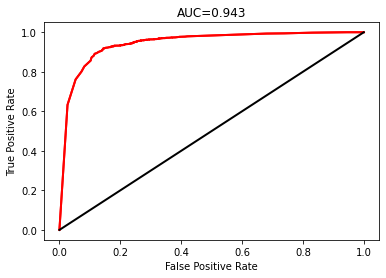

In [30]:
plot_auc(test_df['label'],test_df['predict'])

In [32]:
fpr, tpr, thresholds = roc_curve(test_df['label'], test_df['predict'])
gmeans = np.sqrt(tpr * (1-fpr))
ix = np.argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))

Best Threshold=0.988472, G-Mean=0.888
